In [1]:
import re
import io
import os
import sys
import csv
import glob
import gzip
import time
import json
import secrets
import pickle
import multiprocessing
import subprocess
import resource
import itertools
from itertools import combinations_with_replacement
import collections
import sqlite3
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import random
from collections import Counter
from collections import defaultdict
import copy
import pyranges as pr
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D

from scipy.stats import nbinom, norm, geom, beta, poisson
from scipy.special import logsumexp

sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
sys.path.append('/Users/sus_zhang/Desktop/Suuuuuuuus/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *

sys.path.append('/well/band/users/rbx225/GAMCC/scripts/lcSV/')
sys.path.append('/Users/sus_zhang/Desktop/Suuuuuuuus/Low Coverage Data/gamcc/scripts/lcSV/')
from lcSV import *

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/
# %cd ../..

/gpfs3/well/band/users/rbx225/GAMCC


<Figure size 100x100 with 0 Axes>

# Calling sex lcWGS

      sample    chrX    chrY sex
72   IDT0735  0.6028  0.4858   F
118  IDT0549  0.5612  0.4986   F
160  IDT0498  0.5774  0.4674   F


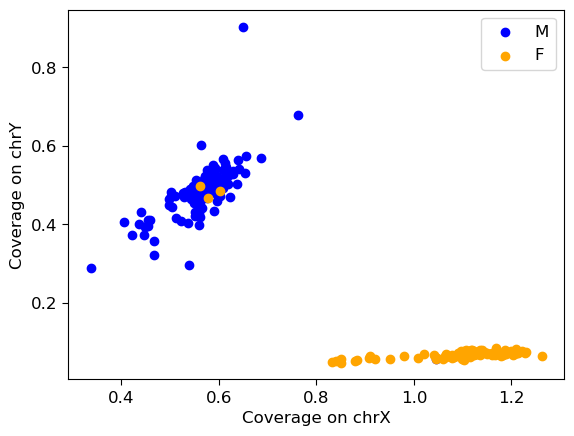

In [2]:
indir = 'results/coverage/sex/'
samples = lcwgsus.read_tsv_as_lst('data/sample_tsvs/fv_idt_names.tsv')

df_lst = []
for i in samples:
    df = pd.read_csv(f'{indir}{i}.sexchr.tsv', sep = '\t', header = None) 
    df.columns = ['sample', 'chrX', 'chrY']
    df_lst.append(df)
df = pd.concat(df_lst).reset_index(drop = True)

metadata = pd.read_csv('data/metadata/sex.csv')
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]

metadata = metadata[metadata['GMID'].isin(sl['Sample_Name'])]
sl = {k:v for k, v in zip(sl['Sample_Name'], sl['Seq_Name'])}
metadata['GMID'] = metadata['GMID'].apply(lambda x: sl[x])
metadata.columns = ['sample', 'sex']
df = pd.merge(df, metadata, on = 'sample')

labels = ['M', 'F']
colors = ['blue', 'orange']
for i, s in enumerate(labels):
    tmp = df[df['sex'] == s]
    if s == 'F':
        print(tmp[tmp['chrY'] > 0.2])
    plt.scatter(tmp['chrX'], tmp['chrY'], color = colors[i], label = s)
plt.xlabel('Coverage on chrX')
plt.ylabel('Coverage on chrY')
plt.legend()

# Coverage at specific regions

In [49]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

## GYP region

### DEL1

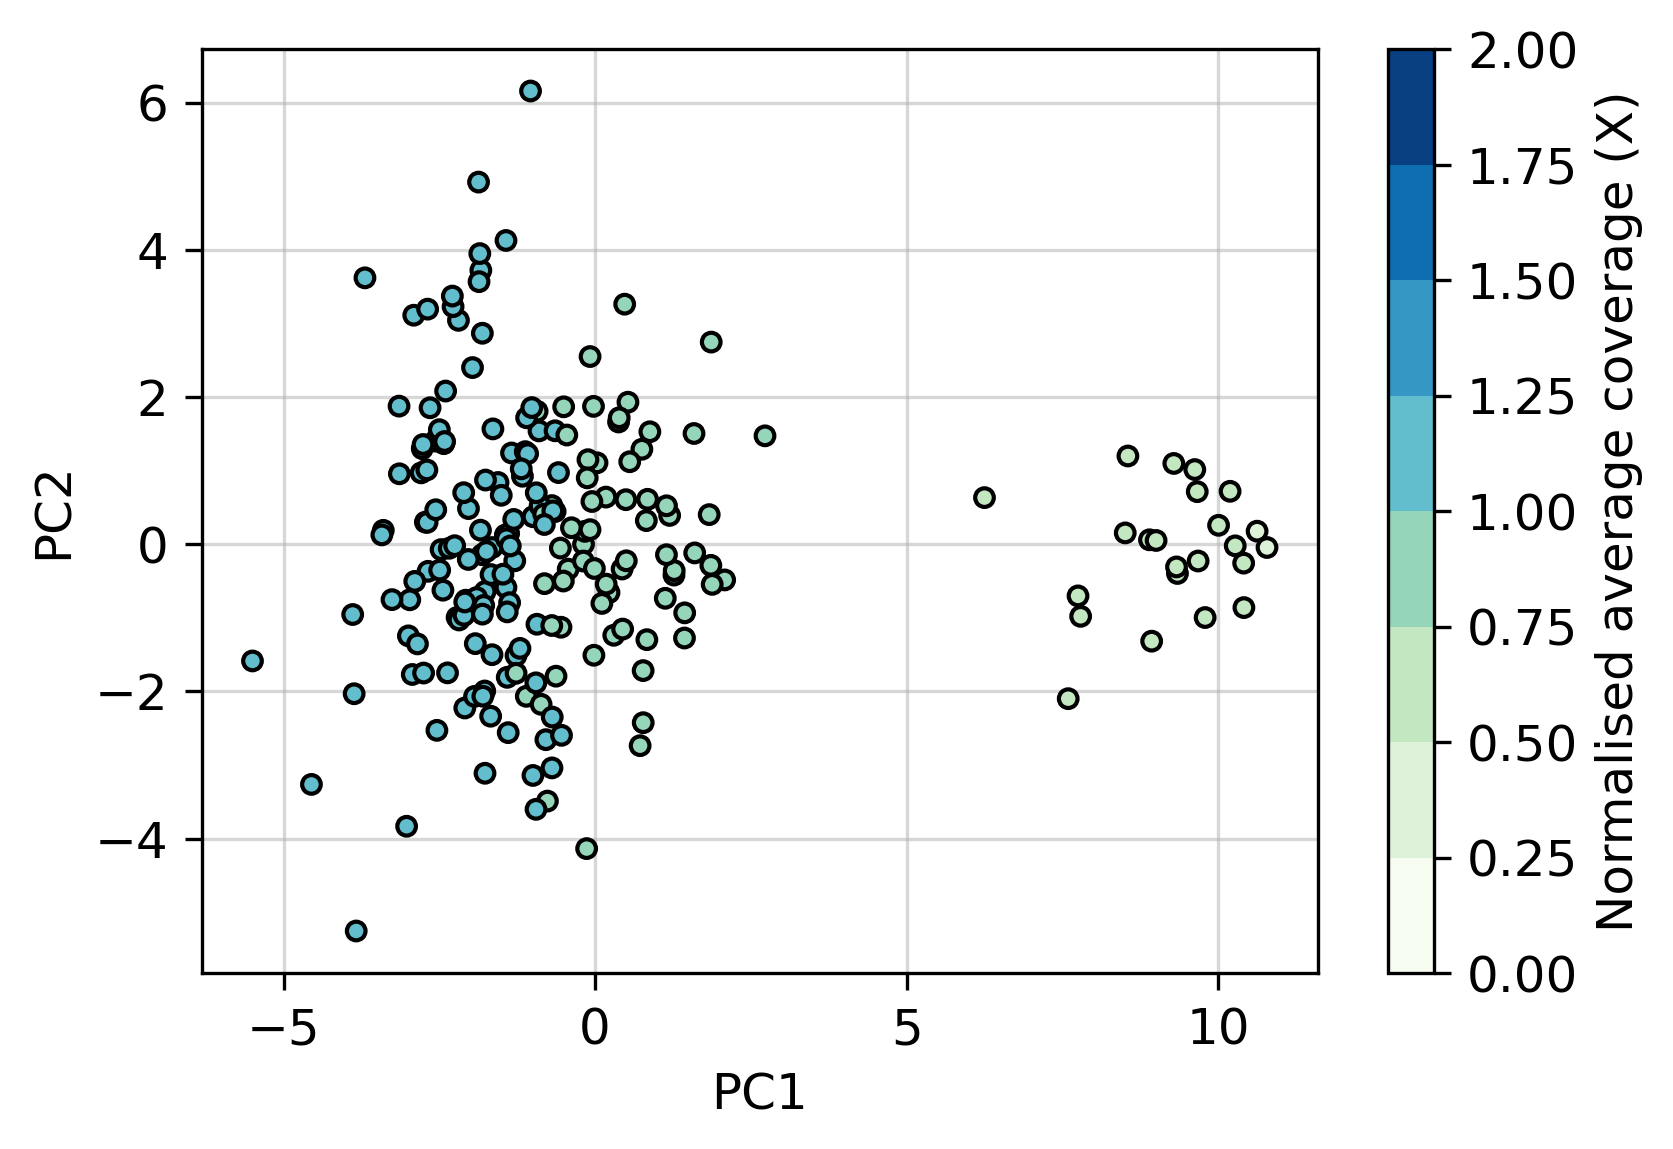

In [93]:
binsize = 1000
chromosome = 4
d1_start = 143910000
d1_end = 144030000
flank = d1_end - d1_start

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['cov'] = avg_coverage

fig = plt.figure(figsize=(6, 4), dpi = 300)

im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = pc_df['cov'],
                     cmap='GnBu', norm=norm, edgecolor='black', s = 20, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

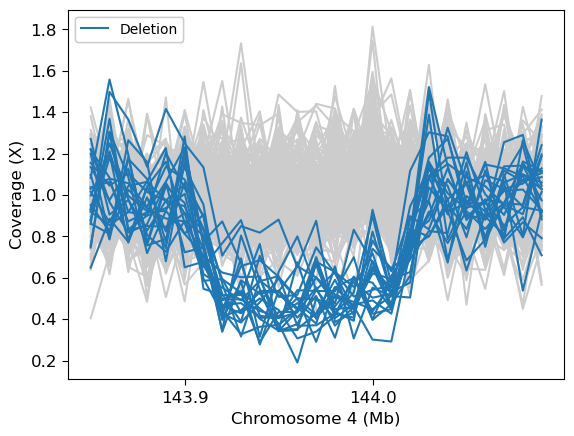

In [91]:
new_window = 10000
tick_step = 0.1
    
cov1 = deresolute_windows(cov, new_window, normalise = True)
del1_region = normalise_by_flank(cov1, d1_start, d1_end, flank)

e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = del1_region[(del1_region['position'] >= fstart) & (del1_region['position'] <= fend)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] < 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] > 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)
    
ticks = get_ticks(del1_region, tick_step)
plt.xticks(ticks, [f"{tick:.{int(np.log10(1/tick_step))}f}" for tick in ticks])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel('Chromosome 4 (Mb)')
plt.ylabel('Coverage (X)')

### DEL1 by Ethnicities

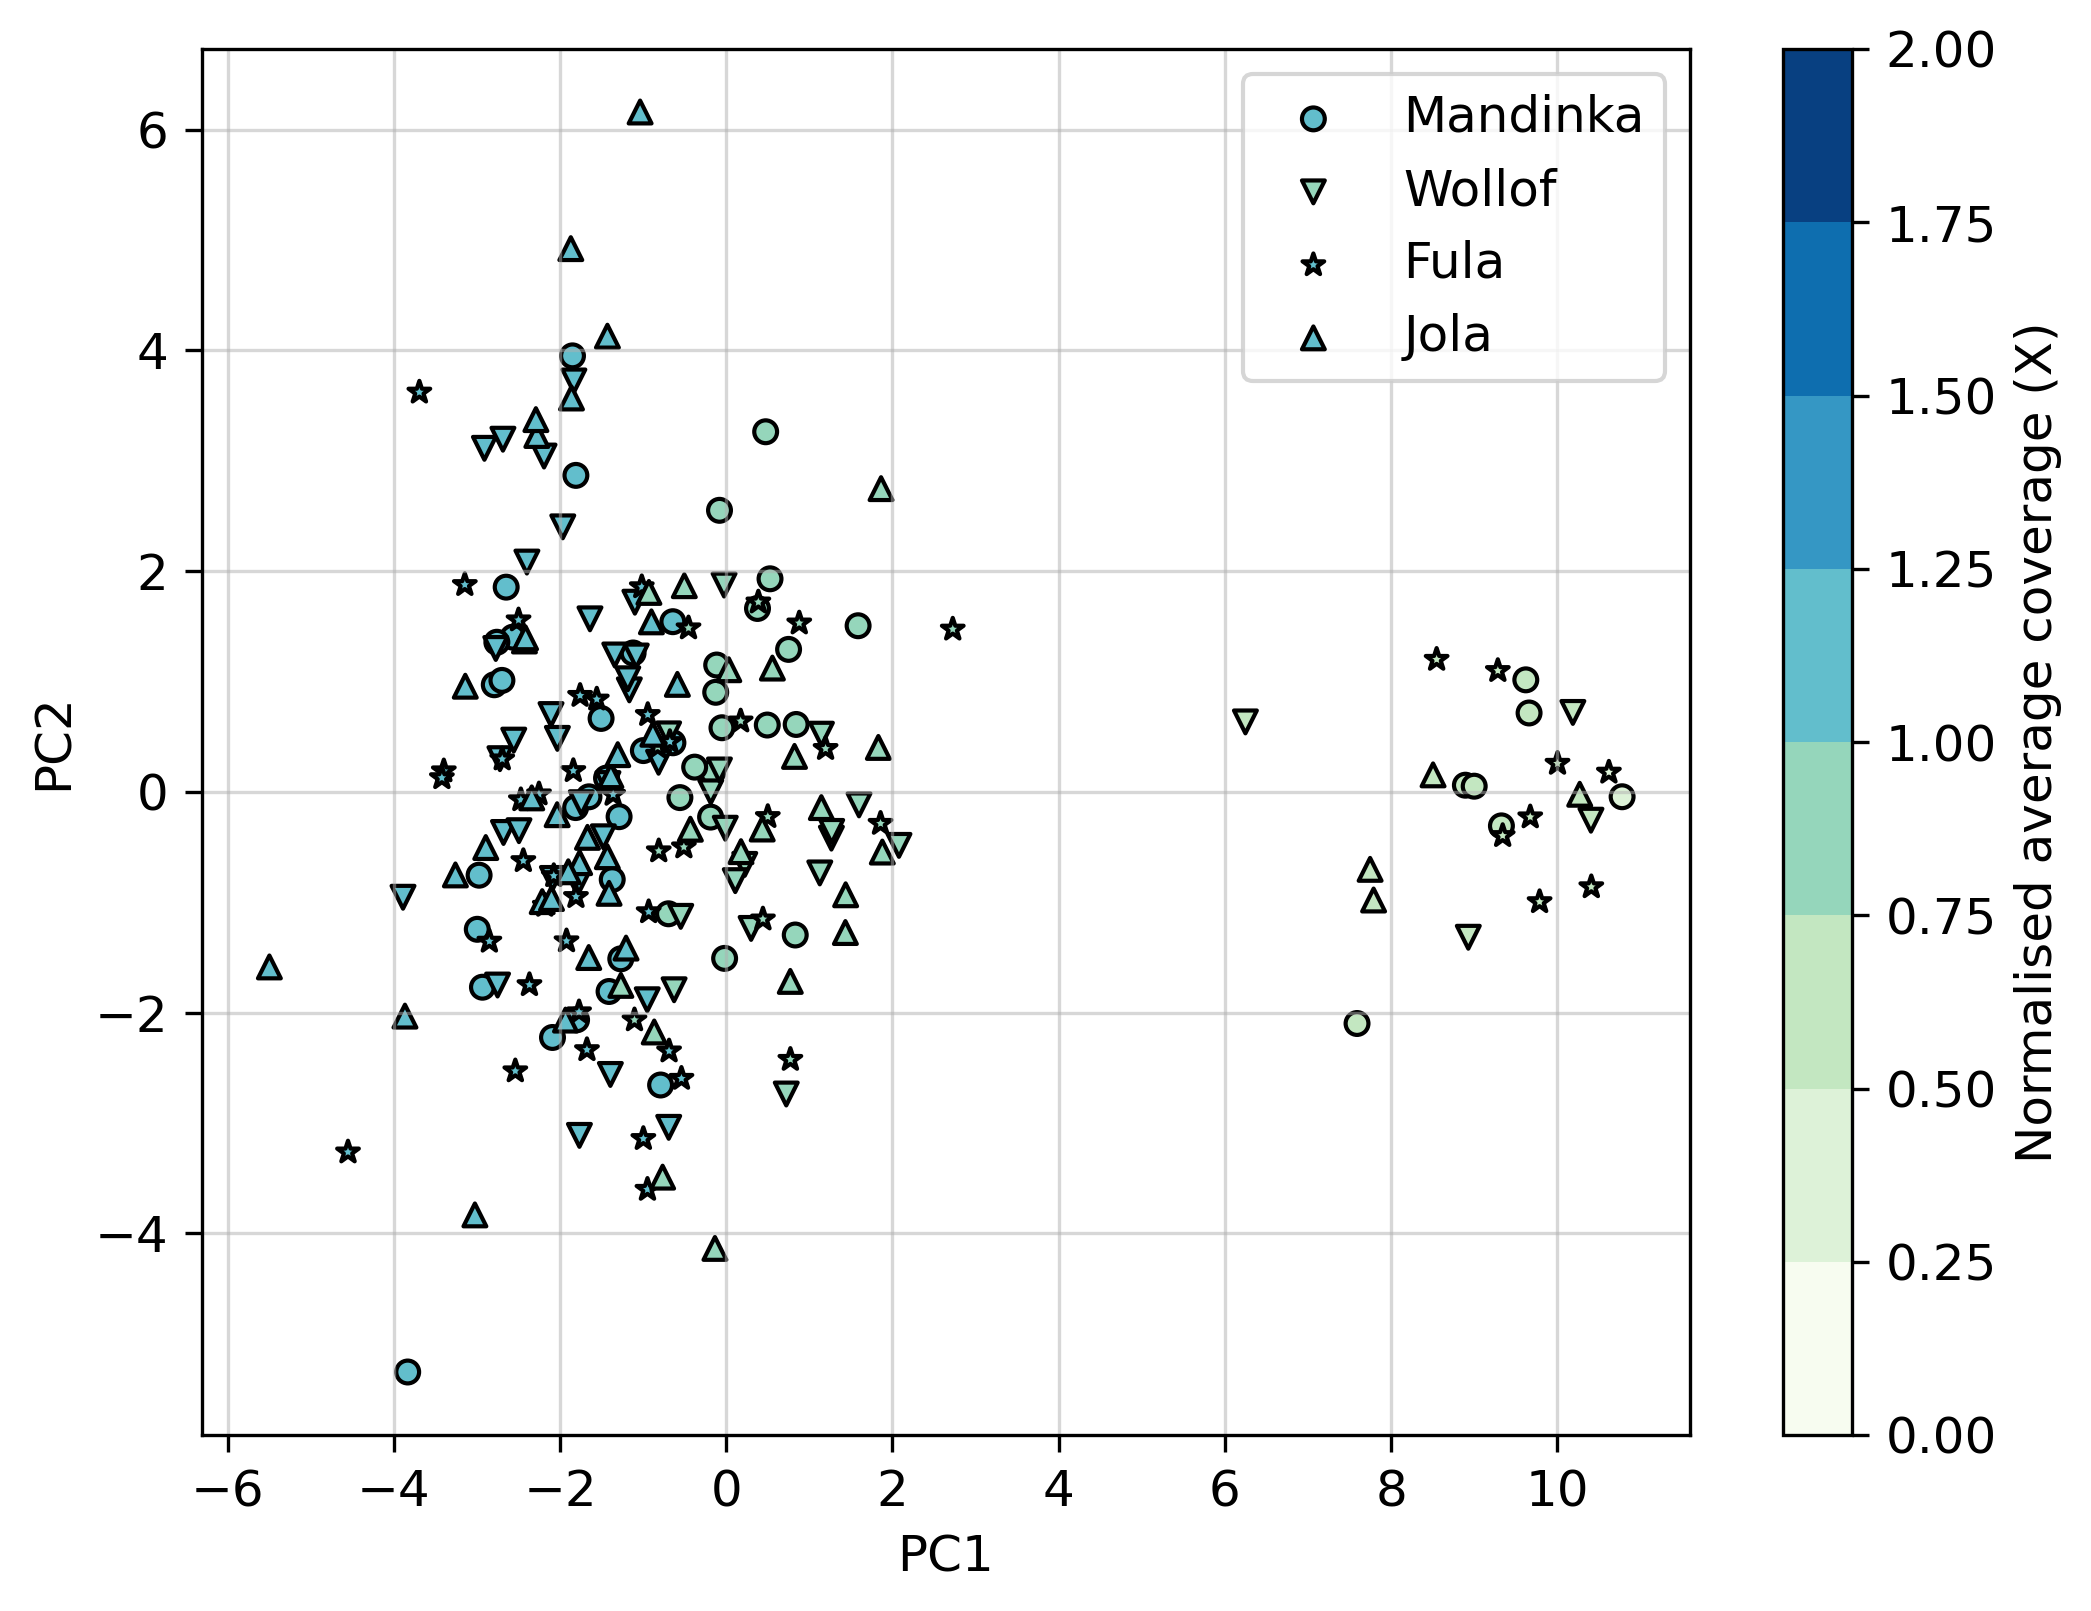

In [28]:
eth = pd.read_csv('data/metadata/ethnic_group.csv')
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]

eth = eth[eth['Chip_Name'].isin(sl['Chip_Name'])]
sl = {k:v for k, v in zip(sl['Chip_Name'], sl['Seq_Name'])}
eth['Chip_Name'] = eth['Chip_Name'].apply(lambda x: sl[x])
eth = eth.sort_values(by = 'Chip_Name').reset_index(drop = True)
ethnicities = eth['ethnic'].unique().tolist()

flank_cov = cov[((cov['position'] >= d1_start - flank) & (cov['position'] < d1_start)) | 
    ((cov['position'] > d1_end) & (cov['position'] <= d1_end+flank))].mean(axis = 0).iloc[1:]

cov1 = cov.copy()
for i, s in enumerate(cov1.columns[1:]):
    cov1[s] = cov1[s]/(flank_cov.loc[s])

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['ethnic'] = eth['ethnic']
pc_df['cov'] = avg_coverage

markers = ['o', 'v', '*', '^']

fig = plt.figure(figsize=(8, 6), dpi = 300)
for i, e in enumerate(ethnicities):
    tmp = pc_df[pc_df['ethnic'] == e]
    im = plt.scatter(tmp['PC1'], tmp['PC2'], c = tmp['cov'], marker = markers[i], 
                     cmap='GnBu', norm=norm, edgecolor='black', s = 30, label = e)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5)

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### DEL2

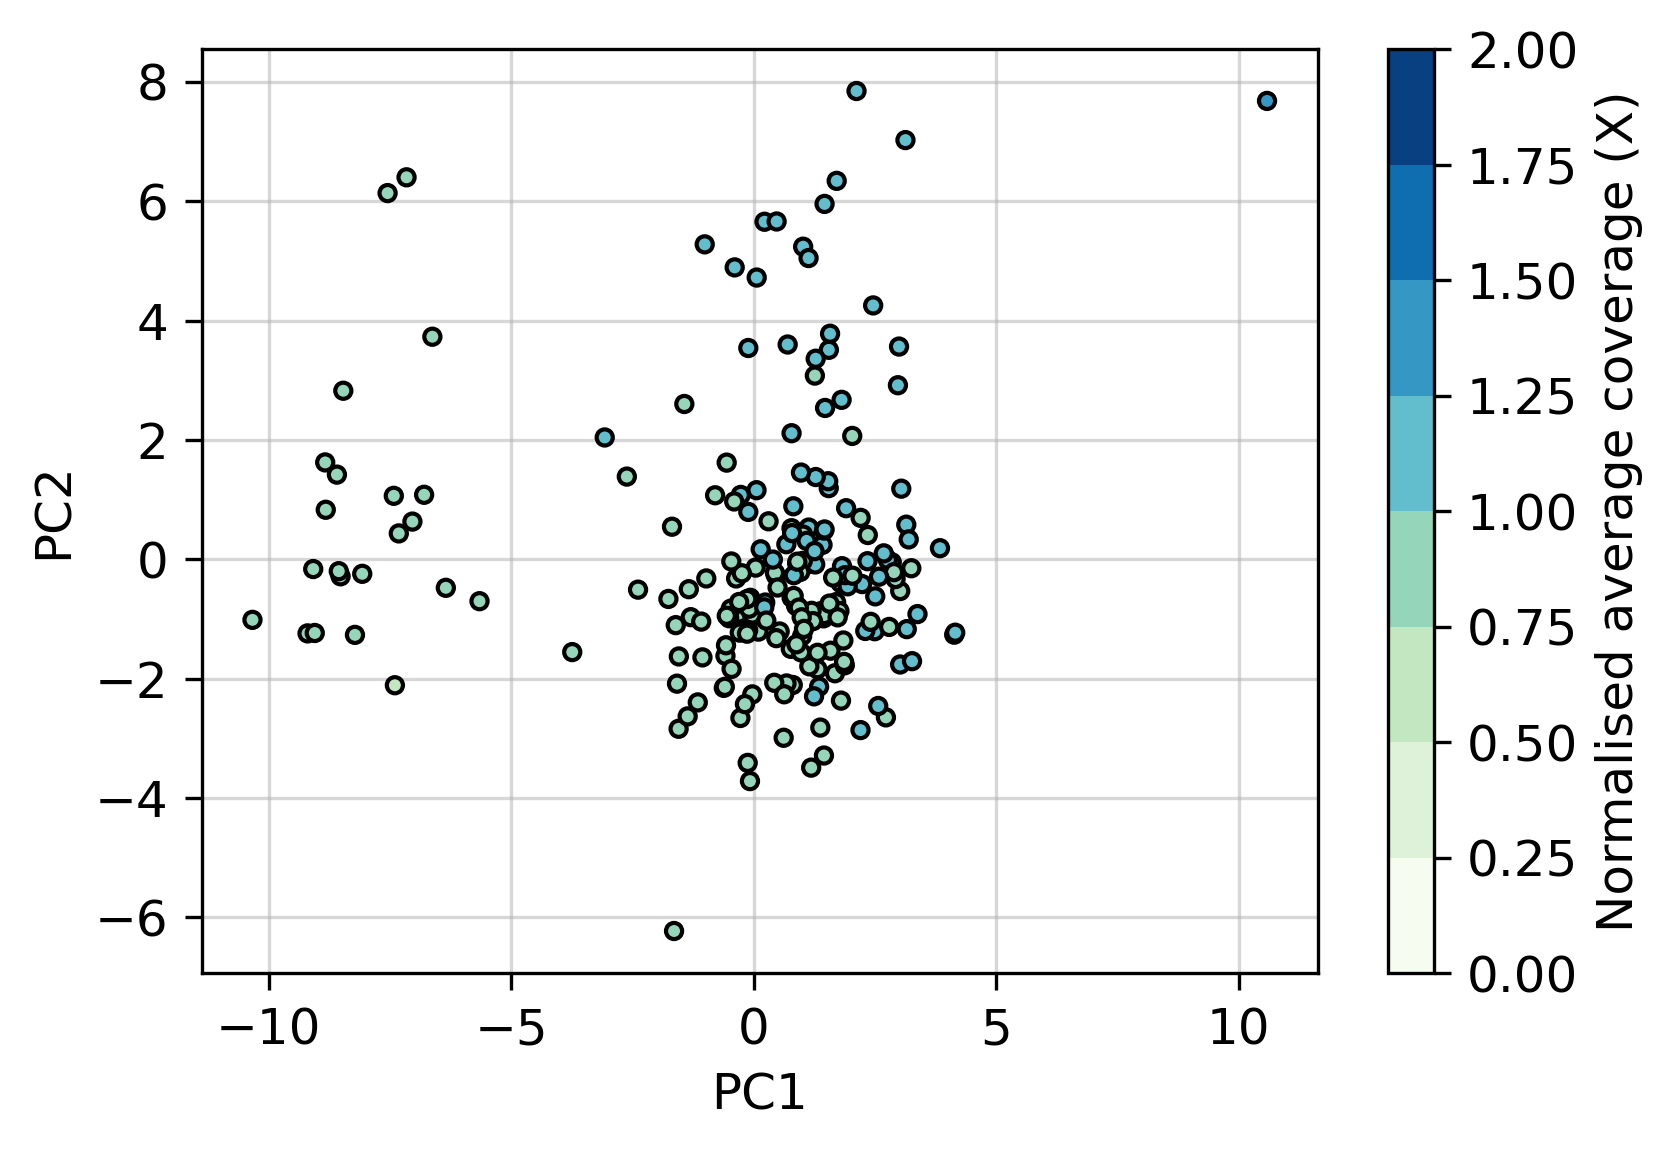

In [172]:
binsize = 1000
chromosome = 4
d1_start = 143780000
d1_end = 143780000 + 210000
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]


fig = plt.figure(figsize=(6, 4), dpi = 300)
# ax = fig.gca()
im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = avg_coverage, cmap='GnBu', norm = norm, edgecolor='black', s = 15, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### DUP1

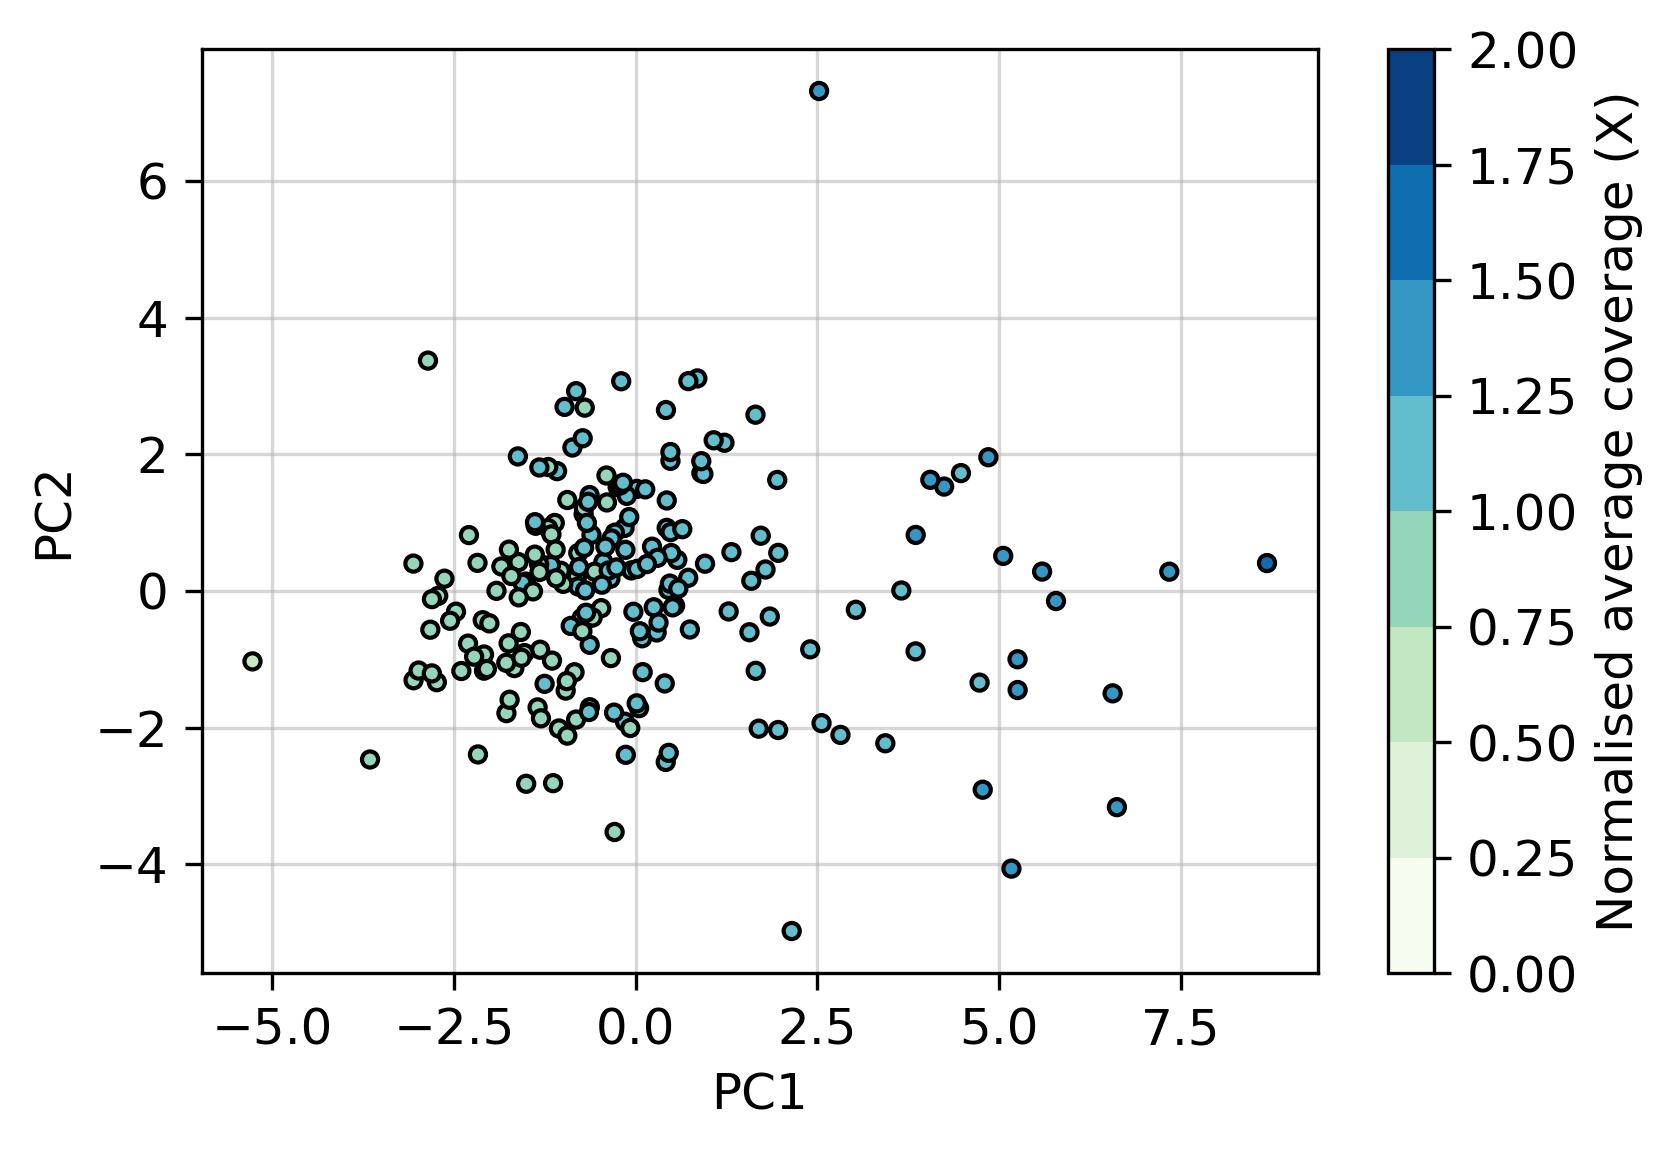

In [50]:
binsize = 1000
chromosome = 4
d1_start = 143790000
d1_end = 143850000
# d1_start = 143778847
# d1_end = 143878847
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]

fig = plt.figure(figsize=(6, 4), dpi = 300)
# ax = fig.gca()
im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = avg_coverage, cmap='GnBu', norm = norm, edgecolor='black', s = 15, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

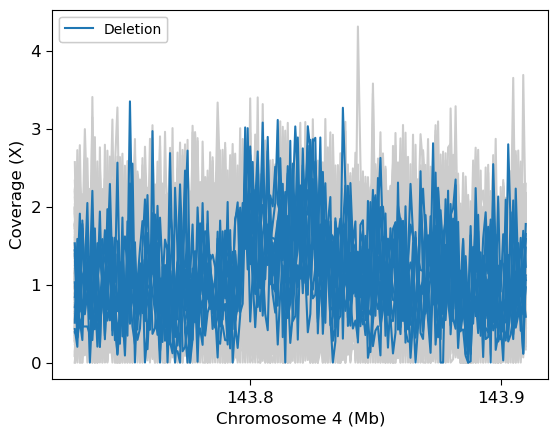

In [51]:
# new_window = 10000
# cov1 = deresolute_windows(cov, new_window, normalise = True)
cov1 = cov.copy()
tick_step = 0.1
e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = normalise_by_flank(cov1, d1_start, d1_end, flank)
del1_region = del1_region[(del1_region['position'] >= d1_start - flank) & (del1_region['position'] <= d1_end + flank)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] < 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] > 5]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)

ticks = get_ticks(del1_region, tick_step)
plt.xticks(ticks, [f"{tick:.{int(np.log10(1/tick_step))}f}" for tick in ticks])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel('Chromosome 4 (Mb)')
plt.ylabel('Coverage (X)')

## HBA region

In [67]:
binsize = 300
chromosome = 16
d1_start = 173598
d1_end = 177378
flank = d1_end - d1_start
e1 = flank/2

cov = load_region_files(regions, chromosome, d1_start, d1_end, flank = flank)
# cov = pd.read_csv('results/coverage/specific_regions/HBA.tsv', sep = '\t')
cov = cov[['position'] + list(cov.columns[cov.columns.str.startswith('IDT') & cov.columns.str.endswith('coverage')])]
cov.columns = ['position'] + [c.replace(':coverage', '') for c in cov.columns[1:]]
cov1 = normalise_by_flank(cov, d1_start, d1_end, flank)

normalized_df = cov1[(cov1['position'] >= d1_start) & (cov1['position'] <= d1_end)].reset_index(drop = True).iloc[:,1:]
zscore_df = (normalized_df - normalized_df.mean(axis=1).values[:, None]) / normalized_df.std(axis=1).values[:, None]

avg_coverage = normalized_df.mean(axis = 0).values.tolist()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(zscore_df.T)  

cmap = plt.get_cmap('GnBu')
magnitude = 8
bounds = np.linspace(0, 2, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pc_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pc_df['Sample'] = cov.columns[1:]
pc_df['cov'] = avg_coverage

fig = plt.figure(figsize=(6, 4), dpi = 300)

im = plt.scatter(pc_df['PC1'], pc_df['PC2'], c = pc_df['cov'],
                     cmap='GnBu', norm=norm, edgecolor='black', s = 20, zorder = 2)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Normalised average coverage (X)')
plt.grid(alpha = 0.5, zorder = 1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Text(0, 0.5, 'Coverage (X)')

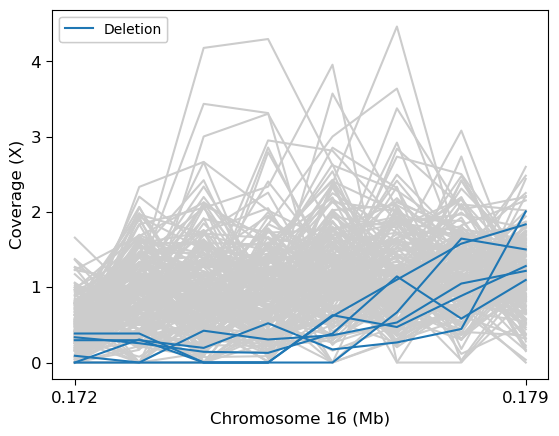

In [68]:
tick_step = 0.001
cutoff = -2

del1_region = cov1

e1 = flank/2
fstart = (d1_start-e1)
fend = (d1_end+e1)

del1_region = del1_region[(del1_region['position'] >= fstart) & (del1_region['position'] <= fend)]
del1_region['position'] = del1_region['position']/1000000

del1 = pc_df[pc_df['PC1'] >= cutoff]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = '0.8')

c = plt.get_cmap(CATEGORY_CMAP_STR).colors[:1][0]
c = mcolors.to_hex(c)

del1 = pc_df[pc_df['PC1'] < cutoff]
for i, s in enumerate(del1['Sample']):
    plt.plot(del1_region['position'], del1_region[s], alpha = 1, color = c)

# ticks = get_ticks(del1_region, tick_step)
plt.xticks([del1_region.iloc[0,0], del1_region.iloc[-1,0]])

color_handles = [
    Line2D([0], [0], color=c, label='Deletion')
]

legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
legend1.get_title().set_fontsize(9)
plt.gca().add_artist(legend1)

plt.xlabel(f'Chromosome {chromosome} (Mb)')
plt.ylabel('Coverage (X)')

# Nonahore

## Generate simulate data

In [161]:
N = 210
nb_var = 300
Ls = [6,12,18,24,30] # translate to 1k, 3k, 6.6k, 10k SVLEN
fs = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
binsize = 1000

mean_coverage = 1.21
sd_coverage = 0.12

replicates = 100
ifiles = glob.glob('results/nonahore/simulate/plausibility/*/eval.pickle')

results_ary = []
for i, ifile in enumerate(ifiles):
    with open(ifile, 'rb') as of:
        data = pickle.load(of)

    results = pd.DataFrame(columns = ['len', 'maf', 'r2', 'info', 'maf_est.'])
    for k, v in data.items():
        results.loc[len(results)] = [float(h) for h in k.split('-')] + v
    results['len'] =  results['len'].apply(lambda x: Ls.index(x))
    results['rep'] = i
    results_ary.append(results)
    
df = pd.concat(results_ary).reset_index(drop = True)
avg = df.groupby(['len', 'maf']).mean().reset_index()

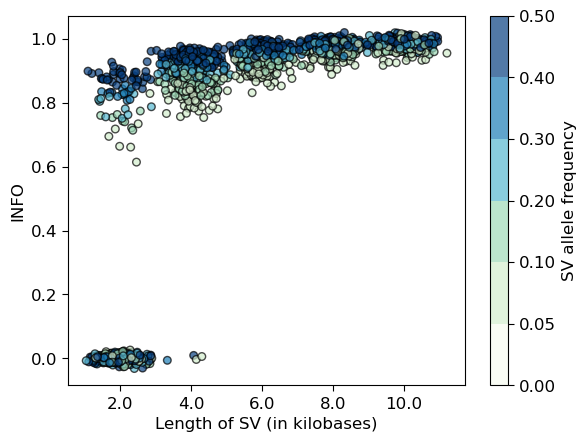

In [163]:
cmap = plt.get_cmap(COLORBAR_CMAP_STR)
magnitude = len(fs)

bounds = [0] + fs
norm = mcolors.BoundaryNorm(bounds, cmap.N)

metrics = 'info'
jitter_x = np.random.normal(loc=0, scale=0.2, size=len(df))
jitter_y = np.random.normal(loc=0, scale=0.01, size=len(df))

im = plt.scatter(df['len'] + jitter_x, df[metrics] + jitter_y, c = df['maf'],
                    edgecolor='black', cmap=cmap, norm=norm, s = 30, marker = 'o', alpha = 0.7)
    
plt.xticks(np.arange(len(Ls)), np.round(np.array(Ls)/3, 2))
plt.xlabel('Length of SV (in kilobases)')
plt.ylabel('INFO')
plt.colorbar(im, boundaries=bounds, ticks = bounds, label='SV allele frequency')

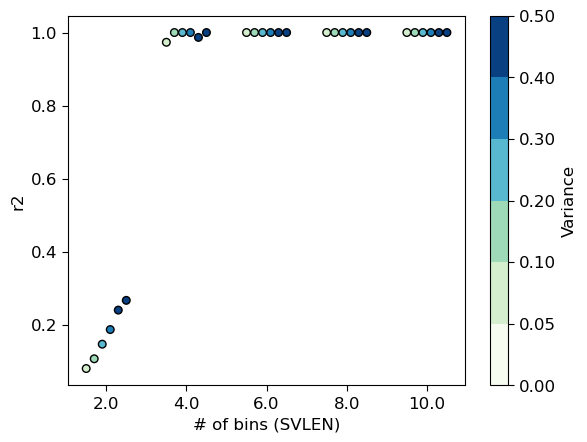

In [165]:
metrics = 'r2'

cmap = plt.get_cmap(COLORBAR_CMAP_STR)
magnitude = len(fs)

bounds = [0] + fs
norm = mcolors.BoundaryNorm(bounds, cmap.N)

jitter = [-0.25,-0.15,-0.05,0.05,0.15,0.25]
xaxis = []
xticks = []

for i, l in enumerate(Ls):
    tmp = avg[avg['len'] == i]
    plt.scatter(tmp['len'] + np.array(jitter), tmp[metrics], c = tmp['maf'],
                    edgecolor='black', cmap=cmap, norm=norm, s = 30, marker = 'o')

plt.xticks(np.arange(len(Ls)), np.round(np.array(Ls)/3, 2))
plt.xlabel('# of bins (SVLEN)')
plt.ylabel(metrics)
plt.colorbar(boundaries=bounds, ticks = bounds, label='Variance')

Text(0, 0.5, 'Concordance')

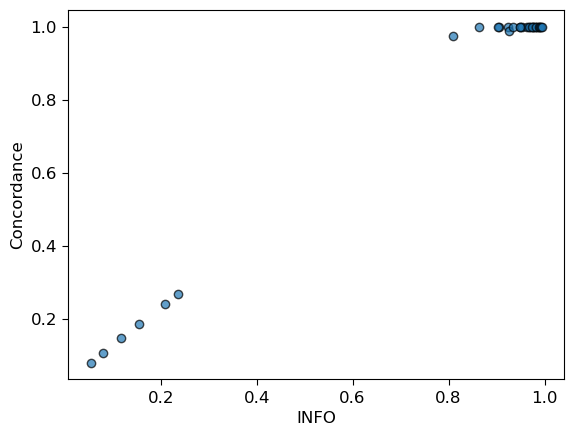

In [166]:
plt.scatter(avg['info'], avg['r2'], ec = 'black', alpha = 0.7)
plt.xlabel('INFO')
plt.ylabel('Concordance')

### Testing a single case

In [67]:
N = 210
nb_vars = 100
Ls = 10
fs = 0.05
replicates = 1
binsize = 1000

mean_coverage = 1.21
sd_coverage = 0.12

n_recomb = 200
n_iter = 500
verbose = False

h1 = np.ones(l)
h2 = h1.copy()
h2[int(l/3):int(2*l/3)] = 0
model = SVModel([h1,h2], [1-f1,f1])
training, coverage, true_gt = simulate_coverotron(model, N, l, mean_coverage, sd_coverage, v)

eval_dict = {}
means = np.mean(training, axis = 0)
variances = np.var(training, axis = 0, ddof = 1)
result_dict = nonahore(means, variances, coverage, n_recomb = n_recomb, n_iter = n_iter, verbose = verbose)
                
concordance, info, freq = evaluate_sim_model(result_dict, h2, true_gt)
concordance, info, freq

(1.0, 1.0, 0.14522695332433527)

## Simulation

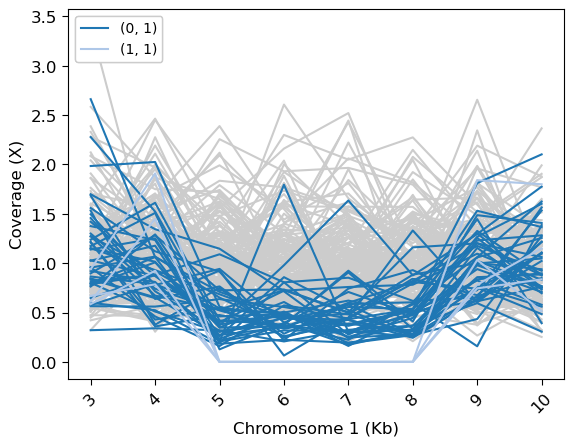

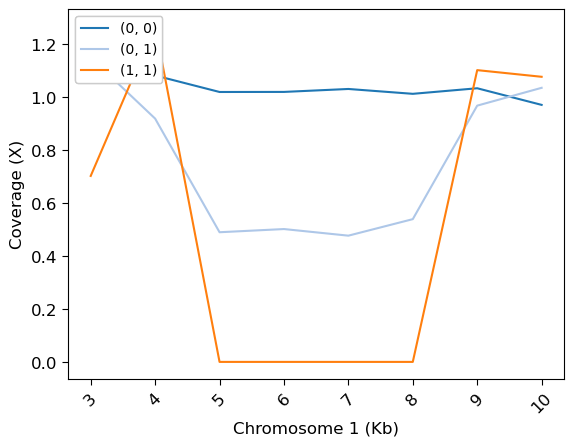

In [195]:
# ploidy = 2
# geom_penalty = 0.9
# max_cnv = 10
# n_iter = 10
# n_sample_freq = 200
# n_recomb = 1000

# indir = "results/nonahore/simulate/plausibility/rep12/"
# cov_file = f"{indir}12-0.1-training.txt"
# covs = pd.read_csv(cov_file, header = None, sep = '\t').to_numpy()
# means = np.mean(covs, axis = 0)
# variances = np.var(covs, axis = 0, ddof = 1)
# # Instead of loading from a file we can also input the matrix

# cov_file = f"{indir}12-0.1-coverage.txt"
# covs = pd.read_csv(cov_file, header = None, sep = '\t').to_numpy()

# results = nonahore(means, variances, covs, n_iter = 50)

# plot_training(results)
# plt.show()

best_model = results['model_ary'][-1]
samples = [f'samples_{i}' for i in range(1,211)]
calling_dict = dict(sorted(call_sv_samples(samples, results['genotypes']).items()))

cov_df = pd.DataFrame(covs, columns = [f'samples_{i}:coverage' for i in range(1,211)])
cov_df['position'] = np.arange(len(cov_df))*1000 + 1000
cov_df = cov_df[['position'] + [f'samples_{i}:coverage' for i in range(1,211)]]
cov_df['total:coverage'] = 0

plot_sv_coverage(cov_df, 1, 3000, 10000, 3000, calling_dict, tick_step = 0.001)
plt.show()
plot_sv_coverage_by_gt(cov_df, 1, 3000, 10000, 3000, calling_dict, tick_step = 0.001)
plt.show()

## GYP: DEL1 and DEL2

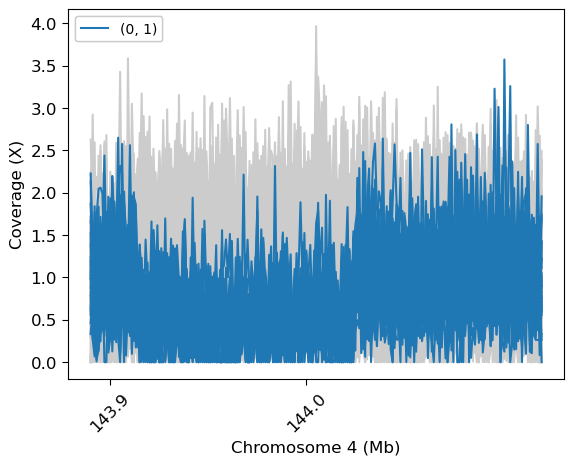

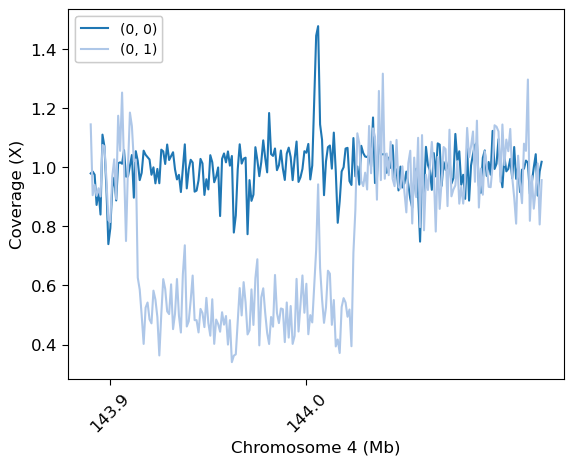

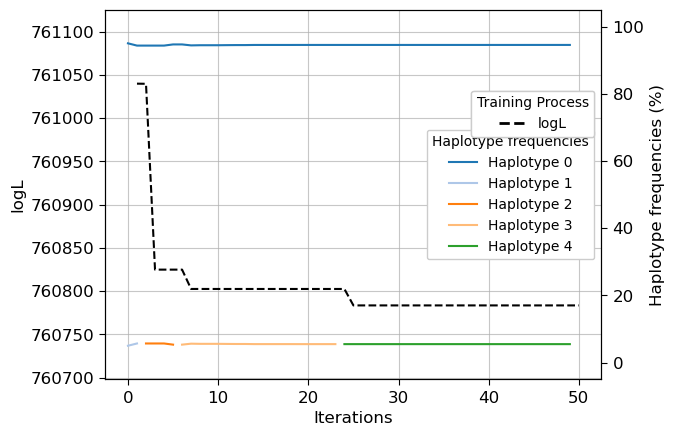

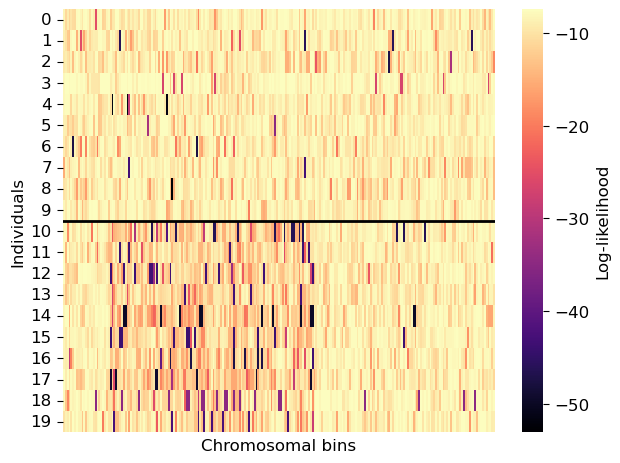

In [149]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000
chromosome = 4
start = 143890000
end = 144120000
flank = end - start

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, n_iter = 50)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results)
plt.show()
plot_sv_heatmap(means, variances, coverage, samples, results)
plt.show()

## DUP1

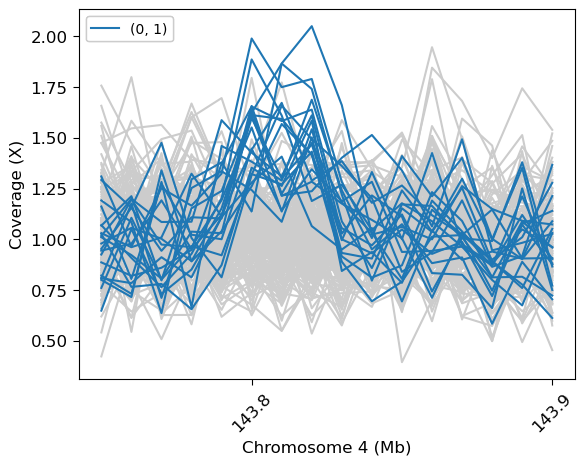

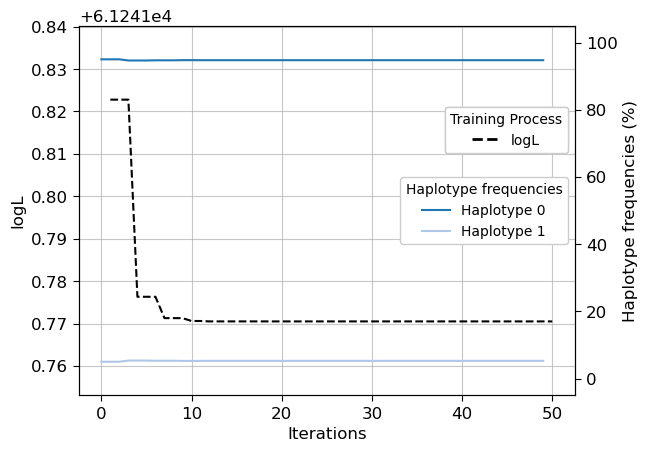

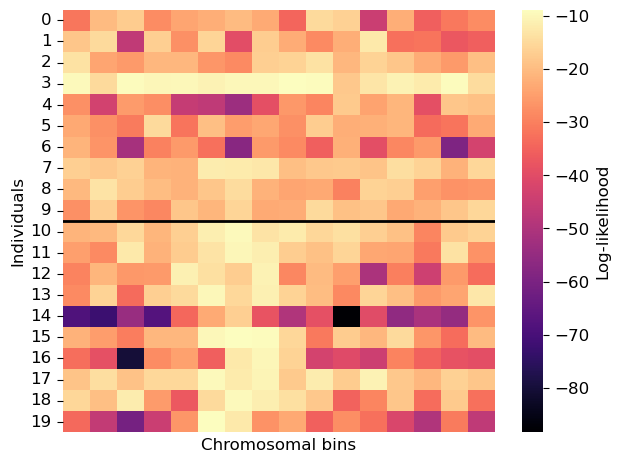

In [2]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000
chromosome = 4
start = 143780000
end = 143850000
flank = end - start

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]

bin_size = 10000
chromosome = 4
start = 143750000
end = 143900000
flank = end - start
cov1 = deresolute_windows(cov, bin_size, normalise = False)
cov = cov1.copy()

means, variances = normalise_by_flank(cov, start, end, flank, side = 'left')
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, samples, n_iter = 50)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results)
plt.show()
plot_sv_heatmap(means, variances, coverage, results)

In [6]:
best_model = results['model_ary'][-1]
L, N = coverage.shape
pre_computed_lls = precompute_site_lls(means, variances, coverage)
geom_penalty = 0.5

lls, _ , model_ll = multi_evaluate_model(best_model, N, pre_computed_lls, geom_penalty)

In [ ]:
# DEL1,2
start = 143890000
end = 144120000
flank = end - start
cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means_del1, variances_del1 = normalise_by_flank(cov, start, end, flank)
print(variances_del1.mean()/(end-start)) ### 1.33

# DUP1
start = 143780000
end = 143850000
flank = end - start
cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means_dup1, variances_dup1 = normalise_by_flank(cov, start, end, flank)
print(variances_dup1.mean()/(end-start)) ### 4.39

## HBA

In [15]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000
chromosome = 16
start = 160000
end = 190000
flank = end-start
# flank = 1e5

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank2(cov, start, end, flank, side = 'right')
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

# plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
# plt.show()
# plot_training(results, show_legends = False)
# plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)

------ Iteration 5 ------
Best loglikelihood: 104041.73629631563
------ Iteration 45 ------
Best loglikelihood: 103665.06128701578
------ Iteration 50 ------
Best loglikelihood: 103665.06128701578
------ Iteration 55 ------
Best loglikelihood: 103665.06128701578
------ Iteration 60 ------
Best loglikelihood: 103665.06128701578
------ Iteration 65 ------
Best loglikelihood: 103665.06128701578
------ Iteration 70 ------
Best loglikelihood: 103665.06128701578
------ Iteration 75 ------
Best loglikelihood: 103665.06128701578
------ Iteration 80 ------
Best loglikelihood: 103665.06128701578
------ Iteration 85 ------
Best loglikelihood: 103665.06128701578
------ Iteration 90 ------
Best loglikelihood: 103665.06128701578
------ Iteration 95 ------
Best loglikelihood: 103665.06128701578
------ Iteration 100 ------
Best loglikelihood: 103665.06128701578
------ Iteration 105 ------
Best loglikelihood: 103665.06128701578
------ Iteration 110 ------
Best loglikelihood: 103665.06128701578
------ I

In [16]:
best_model.haps

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
 array([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1.]),
 array([1., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 0., 0., 0., 0., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1.])]

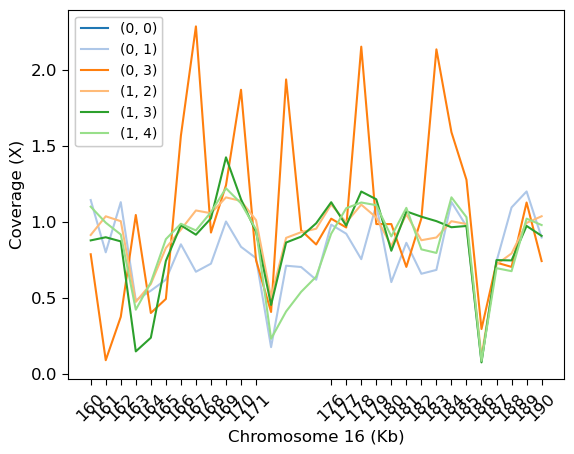

In [199]:
# plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict, tick_step = 0.001)
# plt.show()
# plot_training(results, show_legends = True)
# plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)
# plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict, tick_step = 0.001)
plt.show()

------ Iteration 5 ------
Best loglikelihood: 72000.46881464103
------ Iteration 10 ------
Best loglikelihood: 71997.95910983323
------ Iteration 15 ------
Best loglikelihood: 71997.95910983323
------ Iteration 20 ------
Best loglikelihood: 71997.95910983323
------ Iteration 25 ------
Best loglikelihood: 71997.95910983323
------ Iteration 30 ------
Best loglikelihood: 71997.39152833034
------ Iteration 35 ------
Best loglikelihood: 71997.34825042705
------ Iteration 40 ------
Best loglikelihood: 71997.34825042705
------ Iteration 45 ------
Best loglikelihood: 71997.34825042705
------ Iteration 50 ------
Best loglikelihood: 71997.34825042705
------ Iteration 55 ------
Best loglikelihood: 71997.32907647727
------ Iteration 60 ------
Best loglikelihood: 71997.07849313229
------ Iteration 65 ------
Best loglikelihood: 71997.07849313229
------ Iteration 70 ------
Best loglikelihood: 71997.07849313229
------ Iteration 75 ------
Best loglikelihood: 71997.07849313229
------ Iteration 80 ------

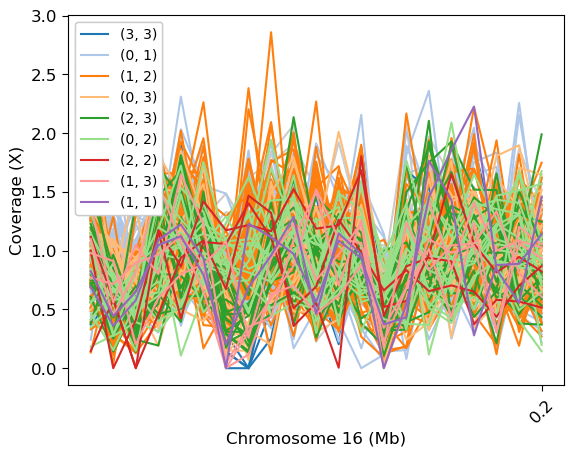

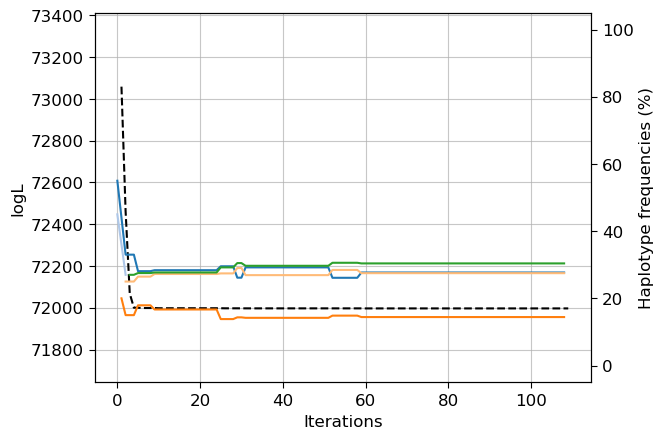

In [7]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 2000
chromosome = 16
start = 160000
end = 200000
flank = end - start

cov = pd.read_csv('results/coverage/specific_regions/HBA.tsv', sep = '\t')
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, samples, 
                   n_recomb = 2000, n_iter = 500, bin_size = bin_size, verbose = True)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results, show_legends = False)
plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)

In [8]:
best_model.haps

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1.]),
 array([1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1.])]

## Eichler

### Eichler generate manifest

In [70]:
# df = pd.read_csv('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz', sep = '\t', compression = 'gzip')
# main_chrs = [f'chr{i}' for i in range(1,23)] + ['X', 'Y']
# df = df[df['#CHROM'].isin(main_chrs)]
# df['PG_AFR_AF'] =  df['PG_INFO_AFR'].str.split(';').str.get(0).str.split('=').str.get(1).astype(float)
# df = df.sort_values(by = 'POP_AFR_AF', ascending = False)
# df = df[(df['SVLEN'] > 5000) & ((df['POP_AFR_AF'] >= 0.05) | (df['PG_AFR_AF'] >= 0.05))]
# df = df[['#CHROM', 'POS', 'END', 'SVTYPE', 'SVLEN','PG_AFR_AF', 'POP_AFR_AF']].reset_index(drop = True)
# df.to_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t', index = False)

df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')

#CHROM        POS        END SVTYPE  SVLEN  PG_AFR_AF  POP_AFR_AF
0      chr8  125582877  125588890    DEL   6013       0.98         1.0
1      chr5   58384165   58390274    DEL   6109       1.00         1.0
2     chr17   72880950   72880951    INS   8066       0.40         1.0
3     chr17   72859877   72859878    INS   6353       1.00         1.0
4      chr3   47784344   47784345    INS   8154       0.87         1.0
...     ...        ...        ...    ...    ...        ...         ...
1174   chr2  143253209  143253210    INS   6066       0.08         0.0
1175   chr2  146105051  146119294    DEL  14243       0.10         0.0
1176   chr2  195227939  195227940    INS   5659       0.06         0.0
1177   chr2  226090355  226097389    DEL   7034       0.06         0.0
1178   chr2  229476839  229476840    INS   6030       0.06         0.0

[1179 rows x 7 columns]

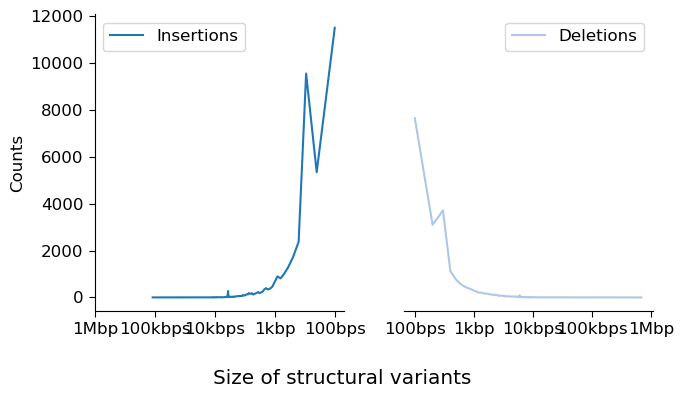

In [59]:
df = pd.read_csv('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz', sep = '\t', compression = 'gzip')
main_chrs = [f'chr{i}' for i in range(1,23)] + ['X', 'Y']
df = df[df['#CHROM'].isin(main_chrs)]
df = df[df['SVLEN'] > 100]
df = df[['SVLEN', 'SVTYPE']]

bin_size = 100
df['bin'] = (df['SVLEN'] // bin_size) * bin_size

insertion = df[df['SVTYPE'] == 'INS']
ins_counts = insertion['bin'].value_counts().sort_index()

deletion = df[df['SVTYPE'] == 'DEL']
del_counts = deletion['bin'].value_counts().sort_index()

xticks = np.logspace(2,6,5)
xlabels = ['100bps', '1kbp', '10kbps', '100kbps', '1Mbp']

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7, 4))

colors = plt.get_cmap(CATEGORY_CMAP_STR).colors[:2]
colors = [mcolors.to_hex(color) for color in colors]

ax1.plot(ins_counts.index, ins_counts.values, color=colors[0], label = 'Insertions')
ax2.plot(del_counts.index, del_counts.values, color=colors[1], label = 'Deletions')

ax1.legend()
ax2.legend()
ax1.invert_xaxis()
ax1.set_xscale('log')
ax1.set_ylabel('Counts')
ax1.set_xticks(xticks, xlabels)
# ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xticks(xticks, xlabels)
# ax2.set_yscale('log')

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False if ax is ax2 else True)  # keep y-axis on leftmost
    ax.spines['bottom'].set_visible(True)

ax2.tick_params(labelleft=False)
ax2.tick_params(axis='y', which='both', length=0)

ax1.tick_params(axis='x', which='minor', length=0)
ax2.tick_params(axis='x', which='minor', length=0)

fig.supxlabel('Size of structural variants')
plt.tight_layout()
plt.show()

In [101]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

ix = 932
chrom, start, L, svtype = df.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region(start, L)
flank = end - start

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

f1 = estimate_maf(means, variances, coverage, svtype)
# plot_maf(coverage, f1)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

# probs, genotypes = results['probs'], results['genotypes']
# info, freq = evaluate_real_model(results)
# haps = results['model_ary'][-1].haps

# outputs = {}
# outputs['chromosome'] = chrom
# outputs['start'] = start
# outputs['end'] = end
# outputs['length'] = L
# outputs['svtype'] = svtype
# outputs['means'] = means
# outputs['variances'] = variances
# outputs['coverage'] = coverage
# outputs['info'] = info
# outputs['freq'] = freq
# outputs['haps'] = haps
# outputs['probs'] = np.round(probs, 4)
# outputs['genotypes'] = genotypes

# best_model = results['model_ary'][-1]
# calling_dict = call_sv_samples(samples, results['genotypes'])

# plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
# plt.show()
# plot_training(results, show_legends = False)
# plt.show()
# # plot_sv_heatmap(means, variances, coverage, samples, results)

------ Iteration 5 ------
Best loglikelihood: 2147679.032761865
------ Iteration 10 ------
Best loglikelihood: 2001036.6233875803


Process ForkPoolWorker-5899:
Process ForkPoolWorker-5898:
Process ForkPoolWorker-5910:
Process ForkPoolWorker-5905:
Process ForkPoolWorker-5897:
Process ForkPoolWorker-5908:
Process ForkPoolWorker-5901:
Process ForkPoolWorker-5896:
Process ForkPoolWorker-5900:
Process ForkPoolWorker-5909:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-5904:
Process ForkPoolWorker-5907:
Process ForkPoolWorker-5903:
Process ForkPoolWorker-5906:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multip

  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/well/band/users/rbx225/GAMCC/scripts/lcSV/lcSV.py", line 311, in evaluate_per_hap
  File "/well/band/users/rbx225/GAMCC/scripts/lcSV/lcSV.py", line 283, in multi_evaluate_model
    final_lls = np.zeros((N, n_diploid))
Traceback (most recent call last):
KeyboardInterrupt
  File "/well/band/users/rbx225/GAMCC/scripts/lcSV/lcSV.py", line 278, in multi_evaluate_model
    if L is None:
  File "/well/band/users/rbx225/GAMCC/scripts/lcSV/lcSV.py", line 278, in multi_evaluate_model
    if L is None:
  File "/well/band/users/rbx225/conda/skylake/envs/sus/lib/python3.8/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starm

KeyboardInterrupt: 

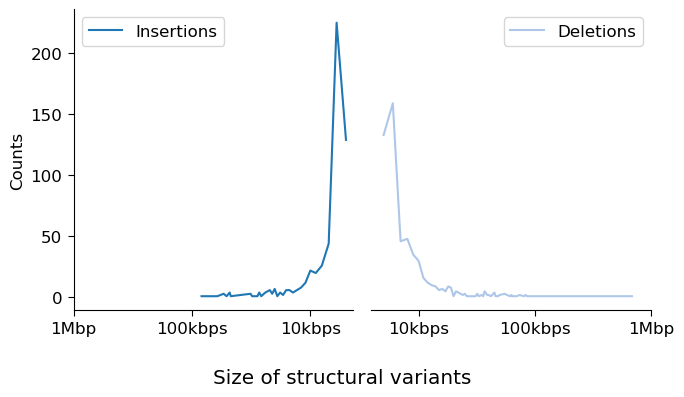

In [60]:
df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
bin_size = 1000
df['bin'] = (df['SVLEN'] // bin_size) * bin_size

insertion = df[df['SVTYPE'] == 'INS']
ins_counts = insertion['bin'].value_counts().sort_index()

deletion = df[df['SVTYPE'] == 'DEL']
del_counts = deletion['bin'].value_counts().sort_index()

xticks = np.logspace(4,6,3)
xlabels = ['10kbps', '100kbps', '1Mbp']

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7, 4))

colors = plt.get_cmap(CATEGORY_CMAP_STR).colors[:2]
colors = [mcolors.to_hex(color) for color in colors]

ax1.plot(ins_counts.index, ins_counts.values, color=colors[0], label = 'Insertions')
ax2.plot(del_counts.index, del_counts.values, color=colors[1], label = 'Deletions')

ax1.legend()
ax2.legend()
ax1.invert_xaxis()
ax1.set_xscale('log')
ax1.set_ylabel('Counts')
ax1.set_xticks(xticks, xlabels)
# ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xticks(xticks, xlabels)
# ax2.set_yscale('log')

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False if ax is ax2 else True)  # keep y-axis on leftmost
    ax.spines['bottom'].set_visible(True)

ax2.tick_params(labelleft=False)
ax2.tick_params(axis='y', which='both', length=0)

ax1.tick_params(axis='x', which='minor', length=0)
ax2.tick_params(axis='x', which='minor', length=0)

fig.supxlabel('Size of structural variants')
plt.tight_layout()
plt.show()

### Eichler test multi-allelic sites

In [10]:
eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
indices = np.where(eichler_full['SVTYPE'] == 'INS')[0]
eichler_full.loc[indices, 'END'] = eichler_full.loc[indices, 'POS'] + eichler_full.loc[indices, 'SVLEN']
eichler_full.loc[indices, 'POS'] = eichler_full.loc[indices, 'POS'] - eichler_full.loc[indices, 'SVLEN']
cols = ['Chromosome', 'Start', 'End']
eichler_full.columns = cols + eichler_full.columns[3:].tolist()
eichler_full = eichler_full.sort_values(by = cols).reset_index(drop = True)

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 396
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
flank = 1e6
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank2(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

# f1 = estimate_maf(means, variances, coverage, svtype)
# plot_maf(coverage, f1)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance = evaluate_real_model2(results, plausible_boundaries)
haps = results['model_ary'][-1].haps

outputs = {}
outputs['chromosome'] = chrom
outputs['g_start'] = sv_start
outputs['start'] = start
outputs['end'] = end
outputs['length'] = L
outputs['svtype'] = svtype
outputs['means'] = means
outputs['variances'] = variances
outputs['coverage'] = coverage
outputs['info'] = info
outputs['freq'] = freq
outputs['concordance'] = concordance
outputs['haps'] = haps
outputs['probs'] = np.round(probs, 4)
outputs['genotypes'] = genotypes

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

# plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
# plt.show()
# plot_training(results, show_legends = True)
# plt.show()
# # plot_sv_heatmap(means, variances, coverage, samples, results)
# # plt.show()
# plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
# plt.show()

------ Iteration 5 ------
Best loglikelihood: 77445.89429821976
------ Iteration 10 ------
Best loglikelihood: 77283.35630041792
------ Iteration 15 ------
Best loglikelihood: 77283.33538017952


KeyboardInterrupt: 

------ Iteration 5 ------
Best loglikelihood: 71808.81922976664
------ Iteration 10 ------
Best loglikelihood: 71808.81433281525
------ Iteration 15 ------
Best loglikelihood: 71808.80812795773
------ Iteration 20 ------
Best loglikelihood: 71808.80812795773
------ Iteration 25 ------
Best loglikelihood: 71808.80812795773
------ Iteration 30 ------
Best loglikelihood: 71808.80812795773
------ Iteration 35 ------
Best loglikelihood: 71808.80812795773
------ Iteration 40 ------
Best loglikelihood: 71808.80812795773
------ Iteration 45 ------
Best loglikelihood: 71808.80812795773
------ Iteration 50 ------
Best loglikelihood: 71808.80812795773
------ Iteration 55 ------
Best loglikelihood: 71808.80812795773
------ Iteration 60 ------
Best loglikelihood: 71808.80812795773
------ Iteration 65 ------
Best loglikelihood: 71808.80812795773
------ Iteration 70 ------
Best loglikelihood: 71808.80812795773
------ Iteration 75 ------
Best loglikelihood: 71808.80812795773
------ Iteration 80 ------

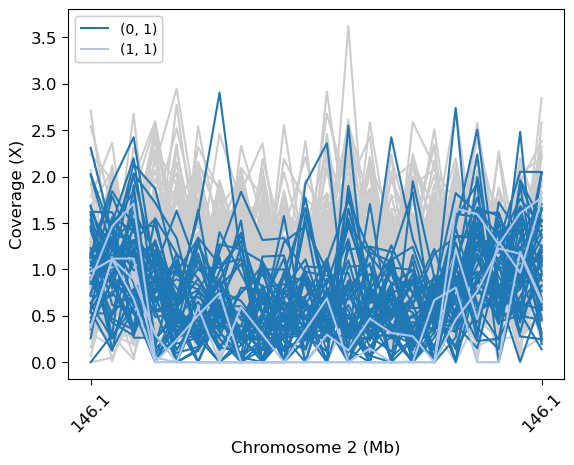

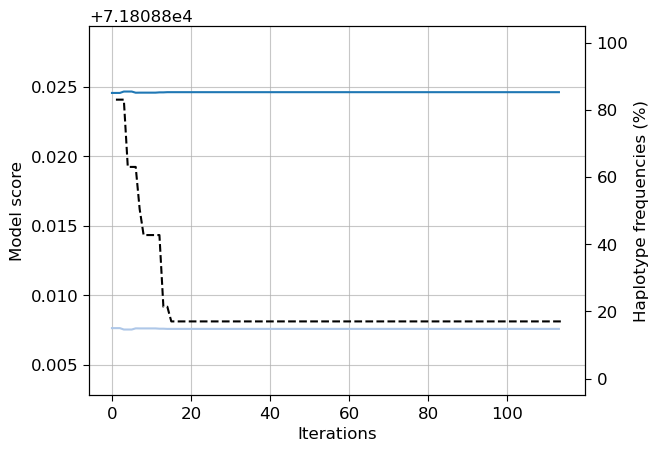

In [188]:
eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
indices = np.where(eichler_full['SVTYPE'] == 'INS')[0]
eichler_full.loc[indices, 'END'] = eichler_full.loc[indices, 'POS'] + eichler_full.loc[indices, 'SVLEN']
eichler_full.loc[indices, 'POS'] = eichler_full.loc[indices, 'POS'] - eichler_full.loc[indices, 'SVLEN']
cols = ['Chromosome', 'Start', 'End']
eichler_full.columns = cols + eichler_full.columns[3:].tolist()
eichler_full = eichler_full.sort_values(by = cols).reset_index(drop = True)

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 1175
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
flank = 1e6
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank2(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)


f1 = estimate_maf(means, variances, coverage, svtype)
plot_maf(coverage, f1)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance = evaluate_real_model2(results, plausible_boundaries)
haps = results['model_ary'][-1].haps

outputs = {}
outputs['chromosome'] = chrom
outputs['g_start'] = sv_start
outputs['start'] = start
outputs['end'] = end
outputs['length'] = L
outputs['svtype'] = svtype
outputs['means'] = means
outputs['variances'] = variances
outputs['coverage'] = coverage
outputs['info'] = info
outputs['freq'] = freq
outputs['concordance'] = concordance
outputs['haps'] = haps
outputs['probs'] = np.round(probs, 4)
outputs['genotypes'] = genotypes

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results, show_legends = True)
plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)
# plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()

In [22]:
cols = ['Chromosome', 'Start', 'End']

gr1 = target.iloc[:,:3]
gr1.columns = cols
gr1['123'] = 0
gr1 = pr.PyRanges(gr1)

insertions = np.where(df['SVTYPE'] == 'INS')[0]
df.loc[insertions, 'END'] = df.loc[insertions, 'POS'] + df.loc[insertions, 'SVLEN']

gr2 = df.iloc[:,:3]
gr2.columns = cols
gr2 = pr.PyRanges(gr2)

non_overlapping = gr1.subtract(gr2)
df3 = non_overlapping.df
df3

Chromosome      Start        End  123
0         chr1    9623989    9630469    0
1         chr1   78489056   78495526    0
2         chr1  103938232  103943510    0
3         chr1  105315155  105321219    0
4         chr1  116439354  116440937    0
..         ...        ...        ...  ...
272      chr22   28059914   28065996    0
273      chr22   38644316   38644446    0
274      chr22   38646826   38648357    0
275      chr22   38648722   38650690    0
276      chr22   46366929   46371355    0

[277 rows x 4 columns]

### Eichler result

In [42]:
# df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')

df = pd.read_csv('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz', sep = '\t', compression = 'gzip')
main_chrs = [f'chr{i}' for i in range(1,23)] + ['X', 'Y']
df = df[df['#CHROM'].isin(main_chrs)]
df['PG_AFR_AF'] =  df['PG_INFO_AFR'].str.split(';').str.get(0).str.split('=').str.get(1).astype(float)
df = df.sort_values(by = 'POP_AFR_AF', ascending = False)
df = df[(df['SVLEN'] > 5000) & ((df['POP_AFR_AF'] >= 0.05) | (df['PG_AFR_AF'] >= 0.05))]
df = df[['#CHROM', 'POS', 'END', 'SVTYPE', 'SVLEN','ID']].reset_index(drop = True)

x = lcwgsus.read_vcf('/well/band/users/rbx225/recyclable_files/eichler_sv/variants_freeze4_sv_insdel_alt.vcf.gz')
x = x[x['ID'].isin(df['ID'])].reset_index(drop = True)
df = pd.merge(df, x[['ID', 'ref', 'alt', 'INFO']], on = ['ID'])
df['TRF'] = df['INFO'].apply(lambda x: 1 if 'REF_TRF' in x else 0)

n_hap_ary = []
info_ary = []
concordance_ary = []
est_freq_ary = []

for ix in range(len(df)):
    infile = f'results/nonahore/eichler/region{ix}/results.pickle'
    if os.path.exists(infile):
        data = read_pickle(infile)
        n_hap_ary.append(len(data['haps']))
        info_ary.append(data['info'])
        est_freq_ary.append(data['freq'])
        concordance_ary.append(data['concordance'])
    else:
        n_hap_ary.append(0)
        info_ary.append(0)
        est_freq_ary.append(0)     
        concordance_ary.append(0)
    
df['n_hap'] = n_hap_ary
df['info'] = info_ary
df['freq'] = est_freq_ary
df['concordance'] = concordance_ary

bed = pd.read_csv('data/bedgraph/GRCh38.autosomes.bed', sep = '\t', header = None)
bed.columns = ['chr', 'start', 'end']

def check_endchr(r, cutoff = 1e6):
    c = r['#CHROM']
    s = r['POS']
    endchr = bed[bed['chr'] == c]['end'].values[0]

    if s > cutoff and s < endchr - cutoff:
        r['is_endchr'] = False
    else:
        r['is_endchr'] = True
    return r
        
df1 = df.copy()
df1['is_endchr'] = False
df1 = df1.apply(check_endchr, axis = 1)
print_avg_concordance(df1)

DEL: 0.8679549114331723
INS: 0.2698961937716263


In [44]:
tmp = df1[df1['TRF'] == 1]
print_avg_concordance(tmp)

DEL: 0.8528225806451613
INS: 0.6013071895424836


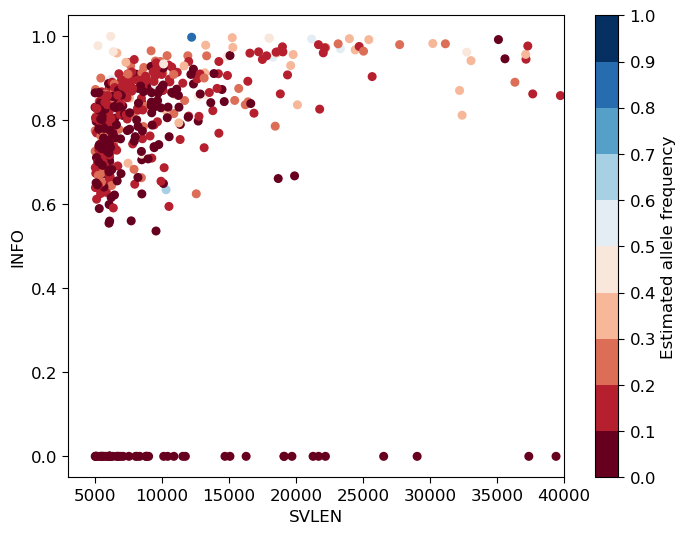

In [63]:
cmap = plt.get_cmap('RdBu')
bounds = np.arange(11)*0.1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

tmp = df[df['SVTYPE'] != 'INS']
im = ax.scatter(tmp['SVLEN'], tmp['info'], c = tmp['freq'], alpha = 1,
                        cmap=cmap,
                        norm=norm,
                        s=30)
plt.colorbar(im,
            boundaries=bounds,
            ticks=bounds,
            label='Estimated allele frequency')
    
plt.xlabel('SVLEN')
plt.ylabel('INFO')
plt.xlim(3000, 40000)
plt.show()

#### ix = 67

In [6]:
df[(df['SVTYPE'] == 'DEL') & (df['concordance'] == 0)]

#CHROM        POS        END SVTYPE  SVLEN  PG_AFR_AF  POP_AFR_AF  n_hap  \
36    chr11    1894042    1915725    DEL  21683        NaN    1.000000      1   
67    chr11   93420970   93427031    DEL   6061       0.85    0.909091      2   
173   chr17   70458945   70465035    DEL   6090       0.71    0.590909      2   
258   chr14   24010409   24015771    DEL   5362       0.25    0.444444      2   
260   chr14  105864253  105904687    DEL  40434        NaN    0.444444      3   
...     ...        ...        ...    ...    ...        ...         ...    ...   
1125   chr1  161571558  161653409    DEL  81851       0.05    0.000000      3   
1132   chr1  108383172  108457633    DEL  74461       0.35    0.000000      2   
1147   chr4    8628442    8634082    DEL   5640       0.42    0.000000      2   
1164  chr18   14804559   14815446    DEL  10887       0.09    0.000000      1   
1167  chr19   39873589   39889865    DEL  16276       0.06    0.000000      2   

      info  freq  concordance  
36     0.0   0.0            0  
67     0.0   0.0            0  
173    0.0   0.0            0  
258    0.0   0.0            0  
260    0.0   0.0            0  
...    ...   ...          ...  
1125   0.0   0.0            0  
1132   0.0   0.0            0  
1147   0.0   0.0            0  
1164   0.0   0.0            0  
1167   0.0   0.0            0  

[82 rows x 11 columns]

------ Iteration 5 ------
Best loglikelihood: 53131.94922853062
------ Iteration 10 ------
Best loglikelihood: 53099.90199369285
------ Iteration 15 ------
Best loglikelihood: 53099.90199369285
------ Iteration 20 ------
Best loglikelihood: 53099.90199369285
------ Iteration 25 ------
Best loglikelihood: 53099.90199369285
------ Iteration 30 ------
Best loglikelihood: 53099.90199369285
------ Iteration 35 ------
Best loglikelihood: 53099.90199369285
------ Iteration 40 ------
Best loglikelihood: 53099.90199369285
------ Iteration 45 ------
Best loglikelihood: 53099.90199369285
------ Iteration 50 ------
Best loglikelihood: 53099.90199369285
------ Iteration 55 ------
Best loglikelihood: 53099.90199369285
------ Iteration 60 ------
Best loglikelihood: 53099.90199369285
------ Iteration 65 ------
Best loglikelihood: 53099.90199369285
------ Iteration 70 ------
Best loglikelihood: 53099.90199369285
------ Iteration 75 ------
Best loglikelihood: 53099.90199369285
------ Iteration 80 ------

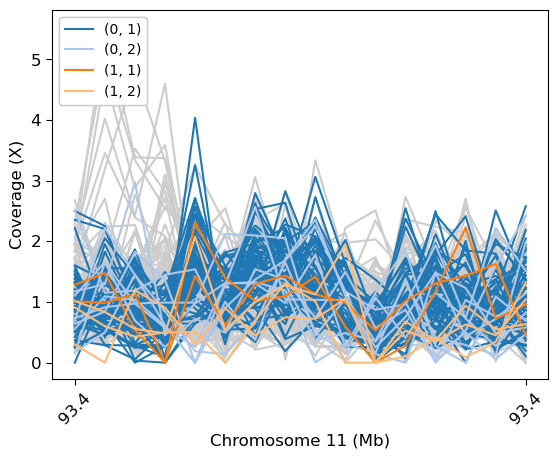

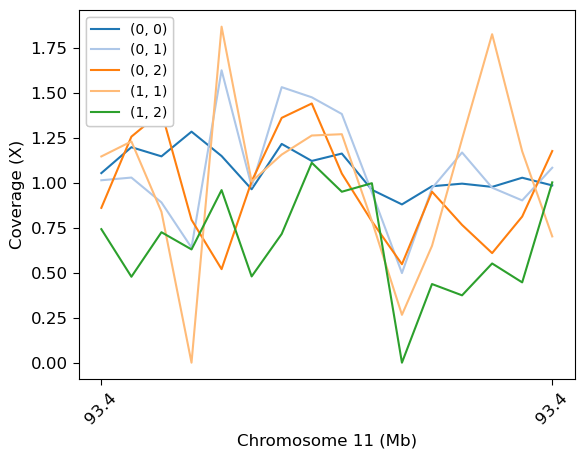

In [20]:
eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
indices = np.where(eichler_full['SVTYPE'] == 'INS')[0]
eichler_full.loc[indices, 'END'] = eichler_full.loc[indices, 'POS'] + eichler_full.loc[indices, 'SVLEN']
eichler_full.loc[indices, 'POS'] = eichler_full.loc[indices, 'POS'] - eichler_full.loc[indices, 'SVLEN']
cols = ['Chromosome', 'Start', 'End']
eichler_full.columns = cols + eichler_full.columns[3:].tolist()
eichler_full = eichler_full.sort_values(by = cols).reset_index(drop = True)

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 67
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
flank = 1e5
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank2(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

# f1 = estimate_maf(means, variances, coverage, svtype)
# plot_maf(coverage, f1)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance = evaluate_real_model2(results, plausible_boundaries, svtype)
haps = results['model_ary'][-1].haps

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()

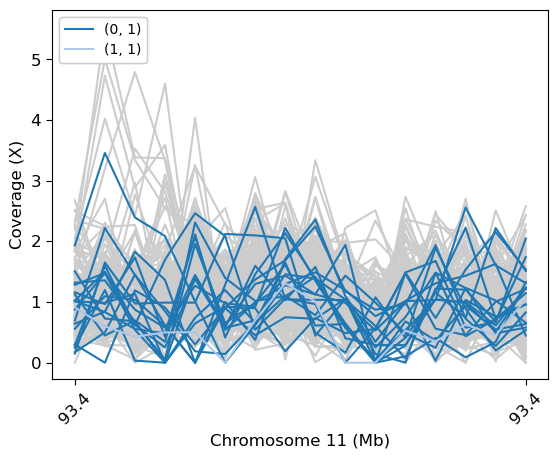

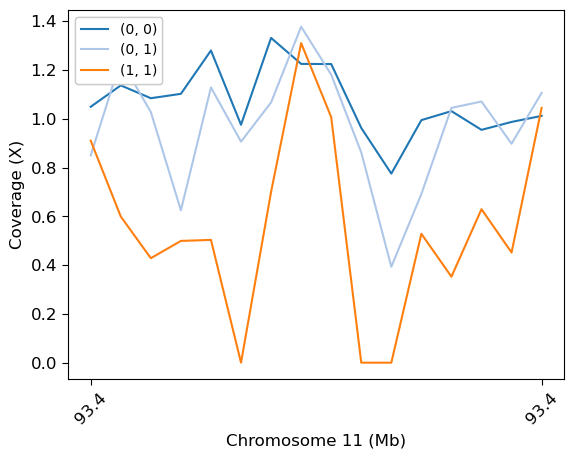

In [12]:
x = read_pickle('results/nonahore/eichler/region67/results.pickle')
x_calling_dict = call_sv_samples(samples, x['genotypes'])
plot_sv_coverage(cov, chromosome, start, end, flank, x_calling_dict)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, x_calling_dict)
plt.show()

In [16]:
eichler_full[(eichler_full['Chromosome'] == 'chr11') & (eichler_full['Start'] >= 93400000) & (eichler_full['Start'] <= 1e8)]

Chromosome     Start       End SVTYPE  SVLEN  PG_AFR_AF  POP_AFR_AF
15802      chr11  93420970  93427031    DEL   6061       0.85    0.909091
15803      chr11  93425266  93428766    INS   1750        NaN    0.045455
15804      chr11  93452043  93452701    INS    329       0.08    0.090909
15805      chr11  93535601  93535973    INS    186       0.00    0.045455
15806      chr11  93552220  93552535    DEL    315       0.00    0.000000
...          ...       ...       ...    ...    ...        ...         ...
15966      chr11  99815185  99815289    INS     52       0.00    0.000000
15967      chr11  99816444  99822182    INS   2869       0.13    0.772727
15968      chr11  99818342  99820262    INS    960       0.56    0.181818
15969      chr11  99858345  99859009    INS    332       0.02    0.136364
15970      chr11  99971278  99971983    DEL    705       0.00    0.045455

[169 rows x 7 columns]

#### ix = 1164

------ Iteration 5 ------
Best loglikelihood: 62923.29305303396
------ Iteration 10 ------
Best loglikelihood: 62921.3691534134
------ Iteration 15 ------
Best loglikelihood: 62921.3691534134
------ Iteration 20 ------
Best loglikelihood: 62921.306599347234
------ Iteration 25 ------
Best loglikelihood: 62921.306599347234
------ Iteration 30 ------
Best loglikelihood: 62921.306599347234
------ Iteration 35 ------
Best loglikelihood: 62921.306599347234
------ Iteration 40 ------
Best loglikelihood: 62921.306599347234
------ Iteration 45 ------
Best loglikelihood: 62921.306599347234
------ Iteration 50 ------
Best loglikelihood: 62921.306599347234
------ Iteration 55 ------
Best loglikelihood: 62921.306599347234
------ Iteration 60 ------
Best loglikelihood: 62921.306599347234
------ Iteration 65 ------
Best loglikelihood: 62921.306599347234
------ Iteration 70 ------
Best loglikelihood: 62921.306599347234
------ Iteration 75 ------
Best loglikelihood: 62921.306599347234
------ Iteration

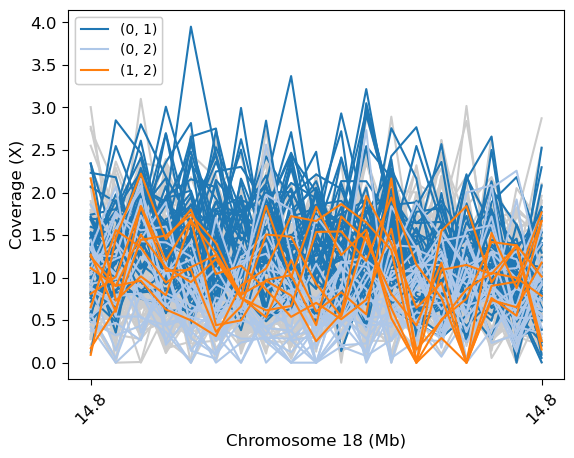

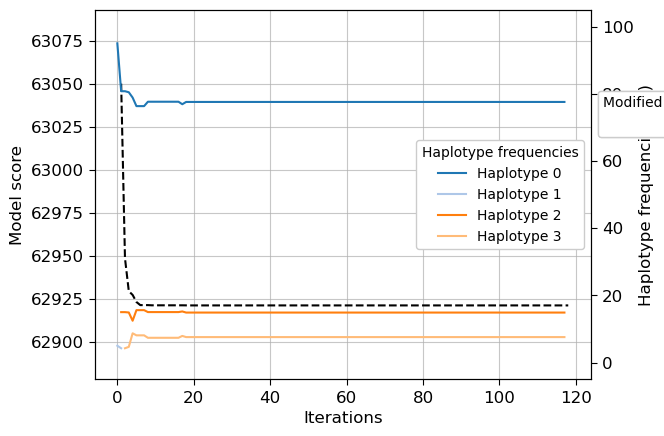

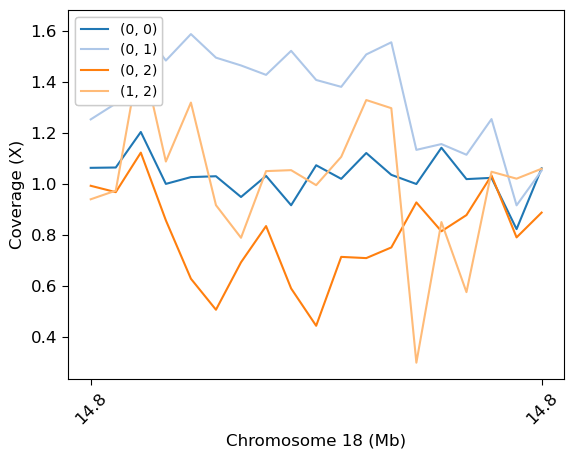

In [2]:
eichler_full = read_eichler('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
indices = np.where(eichler_full['SVTYPE'] == 'INS')[0]
eichler_full.loc[indices, 'END'] = eichler_full.loc[indices, 'POS'] + eichler_full.loc[indices, 'SVLEN']
eichler_full.loc[indices, 'POS'] = eichler_full.loc[indices, 'POS'] - eichler_full.loc[indices, 'SVLEN']
cols = ['Chromosome', 'Start', 'End']
eichler_full.columns = cols + eichler_full.columns[3:].tolist()
eichler_full = eichler_full.sort_values(by = cols).reset_index(drop = True)

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

manifest = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
ix = 1164
chrom, sv_start, L, svtype = manifest.loc[ix, ['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
chromosome = int(chrom.replace('chr', ''))
start, end = delineate_region2(eichler_full, chrom, sv_start, L, svtype)
flank = 1e5
plausible_boundaries = get_sv_boundaries(start, end, sv_start, L, svtype)

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank2(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

# f1 = estimate_maf(means, variances, coverage, svtype)
# plot_maf(coverage, f1)

results = nonahore(means, variances, coverage, n_recomb = 1000, n_iter = 500, verbose = True)

probs, genotypes = results['probs'], results['genotypes']
info, freq, concordance = evaluate_real_model2(results, plausible_boundaries, svtype)
haps = results['model_ary'][-1].haps

outputs = {}
outputs['chromosome'] = chrom
outputs['g_start'] = sv_start
outputs['start'] = start
outputs['end'] = end
outputs['length'] = L
outputs['svtype'] = svtype
outputs['means'] = means
outputs['variances'] = variances
outputs['coverage'] = coverage
outputs['info'] = info
outputs['freq'] = freq
outputs['concordance'] = concordance
outputs['haps'] = haps
outputs['probs'] = np.round(probs, 4)
outputs['genotypes'] = genotypes

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results, show_legends = True)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()

In [8]:
haps

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]),
 array([1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1.,
        1., 1.]),
 array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1.])]

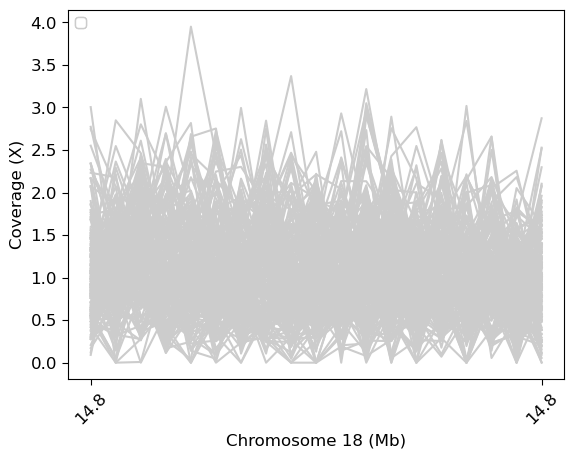

In [24]:
x = read_pickle(f'results/nonahore/eichler/region{ix}/results.pickle')
x_calling_dict = call_sv_samples(samples, x['genotypes'])
plot_sv_coverage(cov, chromosome, start, end, flank, x_calling_dict)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, x_calling_dict)
plt.show()

In [9]:
eichler_full[(eichler_full['Chromosome'] == 'chr18') & (eichler_full['Start'] <= 5e7) 
             & (eichler_full['SVLEN'] >= 5000) & (eichler_full['SVTYPE'] == 'INS')]

Chromosome     Start       End SVTYPE  SVLEN  PG_AFR_AF  POP_AFR_AF
39873      chr18   1817744   1862812    INS  22534       0.37    0.545455
40118      chr18  10621149  10633231    INS   6041       0.07    0.047619
40201      chr18  12485025  12497479    INS   6227       0.24    0.500000
40360      chr18  15089200  15101296    INS   6048        NaN    0.400000
40419      chr18  22545031  22556419    INS   5694       0.82    0.818182
40724      chr18  36743789  36755835    INS   6023       0.00    0.045455
40827      chr18  42310766  42323174    INS   6204       0.00    0.045455

### Look at specific regions

In [9]:
df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
tmp = df[df['#CHROM'] == 'chr19']
tmp = tmp[(tmp['POS'] >= 54273812) & (tmp['POS'] <= 54638022)]
tmp

#CHROM       POS       END SVTYPE  SVLEN  PG_AFR_AF  POP_AFR_AF
32  chr19  54297003  54297004    INS   6759       0.82         1.0

In [10]:
ix = 32
infile = f'results/nonahore/eichler/region{ix}/results.pickle'

data = read_pickle(infile)
n_haps = len(data['haps'])
info = data['info']
freq = data['freq']

print(n_haps, info, freq)

3 0 0


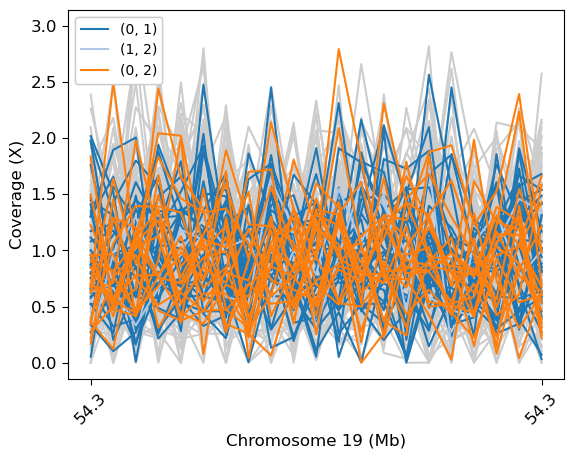

In [12]:
cov = data['coverage']
chromosome = 19
start = 54290000
end = 54310000
flank = end-start

chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]

samples = lcwgsus.read_tsv_as_lst('data/sample_tsvs/fv_idt_names.tsv')
calling_dict = call_sv_samples(samples, data['genotypes'])
plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
# plot_training(results, show_legends = False)
# plt.show()
# plot_sv_heatmap(means, variances, coverage, samples, results)

## denovo

### Simulation

In [174]:
l = 20
f1 = 0.2
N = 210
v = 100

h1 = np.ones(l)
h2 = h1.copy()
h2[int(l/3):int(2*l/3)] = 0

coverage = pd.read_csv(f'results/nonahore/simulate/plausibility/rep0/{v}-{l}-{f1}-coverage.txt', sep = '\t', header = None).to_numpy()
this_vars = (coverage.var(axis = 1))

tmp = coverage[h2 != 0, :]
means = tmp.mean(axis = 0)/2
variances = tmp.var(axis = 0, ddof = 1)/2

EM = means.mean()
DM = means.var(ddof = 1)
V = variances.mean()
EX = 2-2*f1
DX = 2*f1*(1-f1)

A = 2*DM - 2*(EM**2)
B = 2*(EM**2-V-4*DM+DM)
C = 4*DM + 2*V-this_vars

delta = B**2-4*A*C
sqrt_term = np.sqrt(delta)
f1 = (-B + sqrt_term) / (2*A)
f2 = (-B - sqrt_term) / (2*A)

fig, ax1 = plt.subplots()

ax1.plot(this_vars, color = 'b', label = 'VarC')
ax1.legend()
ax1.set_ylabel('Realised variance of coverage')
ax2 = ax1.twinx()
ax2.plot(f1, color = 'orange', label = 'MAF est.')
ax2.legend()
ax2.set_ylabel('Estimated SV allele frequency')

Text(0, 0.5, 'Estimated SV allele frequency')

### Real

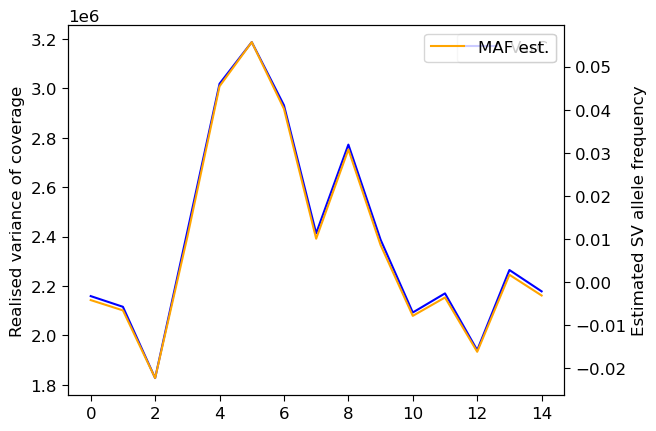

In [230]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 5000
chromosome = 4
start = 143780000
end = 143850000
flank = end - start
svtype = 'INS'

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
cov = deresolute_windows(cov, bin_size)

means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

f1 = estimate_maf(means, variances, coverage, svtype)

this_vars = coverage.var(axis = 1)

plot_maf(coverage, f1)

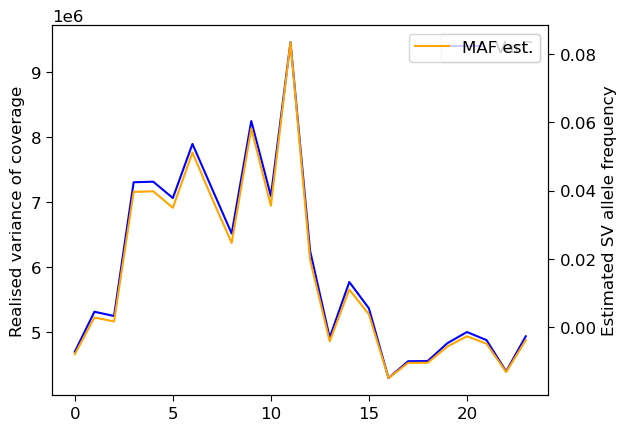

In [265]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 10000
chromosome = 4
start = 143890000
end = 144120000
flank = end - start
svtype = 'DEL'

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
cov = deresolute_windows(cov, bin_size)

means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

f1 = estimate_maf(means, variances, coverage, svtype)

this_vars = coverage.var(axis = 1)

plot_maf(coverage, f1)

### denovo detection generate manifest

In [148]:
plt.plot(cov.var(axis = 1))
plt.yscale('log')
plt.xlabel('bins')
plt.ylabel('per-bin variance')

Text(0, 0.5, 'per-bin variance')

In [323]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000

crit_ary = []
for c in range(1,23):
    this_chr_fstart = regions[f'{c}']['start'][0]
    this_chr_fend = regions[f'{c}']['end'][-1]

    cov = load_region_files(regions, c, this_chr_fstart, this_chr_fend)
    cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]

    means = cov.iloc[:,1:-1].mean(axis = 0).values
    coverage = cov.iloc[:,1:-1].to_numpy()

    variances = 300000*np.ones(coverage.shape[1])

    f1 = estimate_maf(means, variances, coverage, 'DEL')
    f2 = estimate_maf(means, variances, coverage, 'INS')

    means = coverage.mean(axis = 1)
    crit1 = find_intervals(means, f1)
    crit1['SVTYPE'] = 'DEL'
    crit2 = find_intervals(means, f2)
    crit2['SVTYPE'] = 'INS'
    crit = pd.concat([crit1, crit2]).reset_index(drop = True)
    crit['#CHROM'] = c
    crit = crit[['#CHROM', 'POS', 'SVLEN', 'SVTYPE']]
    crit_ary.append(crit)

df = pd.concat(crit_ary)
df['#CHROM'] = 'chr' + df['#CHROM'].astype(str)
df['POS'] = df['POS']*bin_size
# df.to_csv('results/nonahore/denovo/manifest.5K.5percent.tsv', sep = '\t', index = None)

### denovo result

In [403]:
df = pd.read_csv('results/nonahore/denovo/manifest.5K.5percent.tsv', sep = '\t')

n_hap_ary = []
info_ary = []
est_freq_ary = []

for ix in range(len(df)):
    infile = f'results/nonahore/denovo/region{ix}/results.pickle'
    if os.path.exists(infile):
        data = read_pickle(infile)
        n_hap_ary.append(len(data['haps']))
        info_ary.append(data['info'])
        est_freq_ary.append(data['freq'])
    else:
        n_hap_ary.append(0)
        info_ary.append(0)
        est_freq_ary.append(0)        
    
df['n_hap'] = n_hap_ary
df['info'] = info_ary
df['freq'] = est_freq_ary
df['SVLEN'] = df['SVLEN']*1000

In [404]:
colors = ['blue', 'orange']
bottom = None  # Start with nothing below the first bars

# Create a base index of x-values (all unique n_hap)
x_vals = sorted(df['n_hap'].unique())

# Initialize a baseline for stacking
cumulative = [0] * len(x_vals)

for i, t in enumerate(df['SVTYPE'].unique()):
    tmp = df[df['SVTYPE'] == t]
    
    # Get value counts and ensure all x positions are present
    tmp_counts = tmp['n_hap'].value_counts().sort_index()
    tmp_counts = tmp_counts.reindex(x_vals, fill_value=0)  # fill missing x values with 0
    
    xs = x_vals
    ys = tmp_counts.values

    plt.bar(xs, ys, bottom=cumulative, color=colors[i], label=t, alpha=0.7, edgecolor='black')
    cumulative = [sum(x) for x in zip(cumulative, ys)]

plt.xlabel('Estimated number of haplotypes')
plt.ylabel('Counts')
plt.title('Eichler')
plt.legend()
plt.show()

In [407]:
colors = ['blue', 'orange']
markers = ['o', '*']
for i, t in enumerate(df['SVTYPE'].unique()):
    tmp = df[df['SVTYPE'] == t]
    plt.scatter(tmp['SVLEN'], tmp['n_hap'], marker = markers[i], color = colors[i], label = t)
    
plt.legend()
plt.xlabel('SVLEN')
plt.ylabel('Est. # haplotypes')
plt.show()

colors = ['blue', 'orange']
plt.scatter(df['SVLEN'], df['n_hap'], marker = 'o', color = colors[0], alpha = 0.5)
    
plt.xlabel('SVLEN')
plt.ylabel('Est. # haplotypes')
plt.xlim((0, 100000))

(0.0, 100000.0)

In [408]:
estimated_df = df[df['n_hap'] == 2]

colors = ['blue', 'orange']
markers = ['o', '*']
plt.scatter(estimated_df['SVLEN'], estimated_df['info'], marker = markers[0], color = colors[0], alpha = 0.5)

plt.xlabel('SVLEN')
plt.ylabel('INFO')
plt.show()

plt.scatter(estimated_df['SVLEN'], estimated_df['info'], marker = markers[0], color = colors[0], alpha = 0.5)

plt.xlim((0, 40000))
plt.xlabel('SVLEN')
plt.ylabel('INFO')
plt.show()

In [406]:
print(len(df))
print(len(df[df['n_hap'] == 2]))
print(len(df[df['info'] >= 0.8]))

1687
396
0


In [417]:
eichler_df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')
df1 = eichler_df[['#CHROM', 'POS', 'SVLEN']]
df1['END'] = df1['POS'] + df1['SVLEN']
df1 = df1[['#CHROM', 'POS', 'END']]
df1.columns = ['chr', 'start', 'end']

df2 = pd.read_csv('results/nonahore/denovo/manifest.5K.5percent.tsv', sep = '\t')
df2['END'] = df2['POS'] + df2['SVLEN']*1000
df2 = df2[['#CHROM', 'POS', 'END']]
df2.columns = ['chr', 'start', 'end']

df1 = df1.sort_values(['chr', 'start']).reset_index(drop=True)
df2 = df2.sort_values(['chr', 'start']).reset_index(drop=True)

# Count overlaps
count = 0
for i, row1 in df1.iterrows():
    # Subset df2 on same chromosome
    sub = df2[df2['chr'] == row1['chr']]
    
    # Check overlap condition: start1 < end2 and end1 > start2
    overlaps = sub[
        (row1['start'] < sub['end']) & 
        (row1['end'] > sub['start'])
    ]
    
    count += len(overlaps)

In [418]:
count

151

# Pangenome

In [3]:
# df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')

# n_hap_ary = []
# info_ary = []
# est_freq_ary = []

# for ix in range(len(df)):
#     infile = f'results/nonahore/eichler/region{ix}/results.pickle'
#     if os.path.exists(infile):
#         data = read_pickle(infile)
#         n_hap_ary.append(len(data['haps']))
#         info_ary.append(data['info'])
#         est_freq_ary.append(data['freq'])
#     else:
#         n_hap_ary.append(0)
#         info_ary.append(0)
#         est_freq_ary.append(0)        
    
# df['n_hap'] = n_hap_ary
# df['info'] = info_ary
# df['freq'] = est_freq_ary
df.to_csv('results/nonahore/eichler/results.5K.5percent.tsv', sep = '\t', index = None)

#CHROM        POS        END SVTYPE  SVLEN  PG_AFR_AF  POP_AFR_AF  n_hap  \
0      chr8  125582877  125588890    DEL   6013       0.98         1.0      4   
1      chr5   58384165   58390274    DEL   6109       1.00         1.0      3   
2     chr17   72880950   72880951    INS   8066       0.40         1.0      3   
3     chr17   72859877   72859878    INS   6353       1.00         1.0      3   
4      chr3   47784344   47784345    INS   8154       0.87         1.0      2   
...     ...        ...        ...    ...    ...        ...         ...    ...   
1174   chr2  143253209  143253210    INS   6066       0.08         0.0      2   
1175   chr2  146105051  146119294    DEL  14243       0.10         0.0      2   
1176   chr2  195227939  195227940    INS   5659       0.06         0.0      2   
1177   chr2  226090355  226097389    DEL   7034       0.06         0.0      2   
1178   chr2  229476839  229476840    INS   6030       0.06         0.0      2   

          info      freq  
0     0.000000  0.000000  
1     0.000000  0.000000  
2     0.000000  0.000000  
3     0.000000  0.000000  
4     0.818236  0.076214  
...        ...       ...  
1174  0.859208  0.050682  
1175  0.941845  0.142552  
1176  0.869972  0.044281  
1177  0.885002  0.164769  
1178  0.823171  0.070232  

[1179 rows x 10 columns]

In [6]:
df = pd.read_csv('results/nonahore/eichler/results.5K.5percent.tsv', sep = '\t')
df = df[df['SVLEN'] <= 100000]
df = df.sort_values(by = 'info', ascending = False)

#CHROM        POS        END SVTYPE   SVLEN  PG_AFR_AF  POP_AFR_AF  \
520    chr4   68508039   68625352    DEL  117313       0.25    0.181818   
686   chr19   42844938   43015693    DEL  170755       0.01    0.105263   
1003   chr4   69257983   69366597    DEL  108614       0.33    0.047619   
1103   chr8   39374555   39529709    DEL  155154       0.09    0.000000   
266    chr1   72300641   72346157    DEL   45516       0.53    0.409091   
...     ...        ...        ...    ...     ...        ...         ...   
442    chr6   22167042   22175528    DEL    8486       0.09    0.227273   
443   chr13   33558675   33564769    DEL    6094       0.15    0.227273   
444   chr21   23886057   23891137    DEL    5080       0.08    0.227273   
445    chr3  131350923  131350924    INS    6145       0.19    0.227273   
589    chr4   66095803   66105277    DEL    9474       0.00    0.136364   

      n_hap      info      freq  
520       2  1.000000  0.197605  
686       2  1.000000  0.028572  
1003      2  1.000000  0.350000  
1103      2  0.999997  0.123814  
266       2  0.999994  0.592861  
...     ...       ...       ...  
442       3  0.000000  0.000000  
443       5  0.000000  0.000000  
444       4  0.000000  0.000000  
445       3  0.000000  0.000000  
589       3  0.000000  0.000000  

[1179 rows x 10 columns]

In [8]:
pang = lcwgsus.read_vcf('/well/band/users/rbx225/recyclable_files/pangenome/pangenome.sv3000.vcf.gz')
pang

chr        pos                     ID  \
0        1     598371        >25130>24892_73   
1        1     629053         >20859>20809_1   
2        1     641040         >20340>19936_1   
3        1     669688         >18096>12814_3   
4        1     669688         >18096>12814_4   
...    ...        ...                    ...   
32748    9  138277817  >77196079>77197015_78   
32749    9  138277817  >77196079>77197015_79   
32750    9  138277817  >77196079>77197015_80   
32751    9  138277817  >77196079>77197015_81   
32752    9  138277817  >77196079>77197015_82   

                                                     ref  \
0                                                      C   
1      TATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAG...   
2      AGCTGAGACTACAGGCACCTACCACCACGCCTGGCTAATTTTTTTT...   
3                                                      G   
4                                                      G   
...                                                  ...   
32748                                                  C   
32749                                                  C   
32750                                                  C   
32751                                                  C   
32752                                                  C   

                                                     alt  QUAL FILTER  \
0      CGACACTCACGCGGGTGCCGTCTCAGCAGCTCACGGTGTGGAAACT...    60   PASS   
1                                                      T    60   PASS   
2                                                      A    60   PASS   
3      GCGGGACAGGGGGTAGGAGGCCATCAGGACAAACACGTGGATACAT...    60   PASS   
4      GCGGGACAGGGGTAGGAGACCATCAAGACAAACACGTGGATACATG...    60   PASS   
...                                                  ...   ...    ...   
32748  CTCAATGGCCTATTTAGGCCCATACCCTACGTCACGGCAGCCTCCG...    60   PASS   
32749  CTCAATGGCCTATTTAGGCCCATACCCTACGTCACGGCAGCCTCCG...    60   PASS   
32750  CTCAATGGCCTATTTAGGCCCATACCCTACGTCACGGCAGCCTCCG...    60   PASS   
32751  CTCAATGGCCTATTTAGGCCCATACCCTACGTCACGGCAGCCTCCG...    60   PASS   
32752  CTCAATGGCCTATTTAGGCCCATACCCTACGTCACGGCAGCCTCCG...    60   PASS   

                                                    INFO FORMAT CHM13  ...  \
0      AC=1;AF=0.0125;AN=80;AT=>25130>25129>25127>251...     GT     0  ...   
1      AC=38;AF=0.475;AN=80;AT=>20859>20858>20857>208...     GT     1  ...   
2      AC=1;AF=0.0125;AN=80;AT=>20340>20339>20333>203...     GT     0  ...   
3      AC=1;AF=0.0125;AN=80;AT=>18096>18095<18085<180...     GT     0  ...   
4      AC=1;AF=0.0125;AN=80;AT=>18096>18095<16478>164...     GT     0  ...   
...                                                  ...    ...   ...  ...   
32748  AC=2;AF=0.023256;AN=86;AT=>77196079>77196080>7...     GT     0  ...   
32749  AC=2;AF=0.023256;AN=86;AT=>77196079>77196080>7...     GT     0  ...   
32750  AC=1;AF=0.011628;AN=86;AT=>77196079>77196093<7...     GT     0  ...   
32751  AC=18;AF=0.209302;AN=86;AT=>77196079>77196093<...     GT     0  ...   
32752  AC=1;AF=0.011628;AN=86;AT=>77196079>77196093<7...     GT     0  ...   

      HG03098 HG03453 HG03486 HG03492 HG03516 HG03540 HG03579 NA18906 NA20129  \
0         .|0     0|0     0|0     0|.     0|0     0|0     0|0     0|0     0|0   
1         .|0     1|0     1|1     0|.     1|1     1|1     1|1     1|1     1|0   
2         .|0     0|0     0|0     0|.     1|0     0|0     0|0     0|0     0|0   
3         .|0     1|0     0|0     0|.     0|0     0|0     0|0     0|0     0|0   
4         .|0     0|0     0|1     0|.     0|0     0|0     0|0     0|0     0|0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
32748     0|0     0|1     0|0     0|0     0|0     0|0     0|0     0|0     1|0   
32749     0|0     0|0     0|0     0|0     0|0     0|0     0|0     0|0     0|0   
32750     0|0     0|0     0|0     0|0     0|0     0|0     0|0     0|0     0|0   
32751     0|0     0|0     0|0     0|0     1|0     1|0     0|0     0|0     0|0   
3275

In [12]:
pang['alt'].str.len().max()

99395